# Identifying Reddit Topics Using K-Means

## Executive Summary

Reddit is an online discussion site, where people come together to bring up and discuss about various topics. A sample of about 6000 reddit posts was provided. The objective of this notebook was to identify the topics present among them. 

The data was preprocessed by cleaning and removal of duplicated entries, and the frequently-appearing terms in the post titles were identified in order to get preliminary insights as to what the topics might be.

Clustering was performed on the the clean post titles. First, the post titles were vectorized using TDF-IDF. After that, the dimensionality of the vectors was reduced using TSVD. The criterion for dimensionality reduction was that the cumulative variance explained needed to be at least 80%. K-Means clustering was then performed and the optimum number(s) of clusters was taken based on internal validation criteria. The clusters formed were interpreted in an attempt to identify the topic of each.

Several possible topics were identified, and are listed below:
* Games
* New Year
* TIL
* Trump
* U.S. Democrats
* Tech Support
* Food
* Web Development
* Market
* Baking and Recipes
* Awards
* Business

## 1. Introduction

<img src='figures/mascot1.jpg'>

#### Topics
On reddit, user posts are self-organized into subjects, using boards called 'subreddits'. 

#### Discussions on reddit
User-generated content is posted on the boards (subreddits), and discussions can be generated:
* Users can comment on other peoples' posts and start or continue a conversation.
* Users can 'upvote' or 'downvote' a post (merit or demerit a post), providing some sort of a score metric for each post.




### Objective

By taking sample post titles, this notebook will attempt to identify the topics present among them, and consequently, reveal the subreddits present among these titles.

## 2. Preliminaries

### Summary of the Methodology
1. Accessing the Data
    * Read the data
    * Determine the format
    * Store in an appropriate object type (whether numpy array, DataFrame, etc.)
2. Preprocessing
    * Clean the data
        * Remove punctuations and 'unnecessary' characters such as emoji
        * Make all letters lowercase
        * Remove duplicated entries
3. Perform EDA
    * Determine the most frequently appearing words to gain insights as to what the clusters might be
4. Clustering
    * Vectorize the post titles using TDF-IDF
    * Perform dimensionality reduction using Truncated SVD
    * Visualize using TSNE (optional)
    * Cluster using K-Means, from k = 2 to k = 20
        * Determine the optimum number(s) of clusters based on internal validation criteria
5. Interpret the Results
    * Subjectively interpret the clusters formed and attempt to identify the topic of each cluster

### Importing Libraries

In [1]:
import string
import re
from collections import Counter
from collections import defaultdict

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family'] = 'serif'
import seaborn as sns
sns.set_context("talk")

mpl.rcParams['lines.markersize'] = 15

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean
from sklearn.metrics import calinski_harabasz_score, silhouette_score

from IPython.display import HTML

from PIL import Image as PILImage

from wordcloud import WordCloud

In [2]:
import sys
sys.path.append('../reddit_mini_project')

from reddit_mini_project.config import text_path

### Accessing the Data

The provided data is composed of post authors and the corresponding post titles, and is stored in the form of a .txt file.

Before working on the data, it was important to see what it looks like.

The text file was opened and its contents were read to ascertain in what format the data was stored.

In [3]:
with open(text_path, 'r', encoding='latin-1') as raw_file:
    raw_text = raw_file.read(500)
raw_text

'\tauthor\ttitle\n0\tPrimotechInc\t7 Interesting Hidden Features of apple ios9\n1\txvagabondx\tNeed an advice on gaming laptop\n2\tnkindustries\tSemi automatic ROPP Capping machine / ROPP Cap Sealing Machine\n3\tPhilo1927\tMicrosoft Plumbs Oceanâ\x80\x99s Depths to Test Underwater Data Center\n4\ttuyetnt171\tOPPO F1 chÃ\xadnh hÃ£ng - Fptshop.com.vn\n5\tonemantwohands\tStewed Ramps w/ Fixings in Helvatia, WV\n6\t[deleted]\t(California) Is it a crime when a Religious figure/ Lecturer has relations with one of his followers\n7\tgran'

It is quite difficult to read, and is full of delimiters, thus it is a .csv file. The read_csv function of pandas was used instead, specifying the tab (\t) delimiter.

In [4]:
raw_df = pd.read_csv(text_path, delimiter='\t', usecols=['author', 'title'])
raw_df.head()

author                                              title
0  PrimotechInc        7 Interesting Hidden Features of apple ios9
1    xvagabondx                    Need an advice on gaming laptop
2  nkindustries  Semi automatic ROPP Capping machine / ROPP Cap...
3     Philo1927  Microsoft Plumbs Ocean’s Depths to Test Underw...
4    tuyetnt171                OPPO F1 chính hãng - Fptshop.com.vn

#### ANALYSIS
The file contains three fields:

1. [index] - number. Enclosed in brackets because this column was not named. We dropped this column and used pandas index instead.
2. author - username of the post author
3. title - the title of the post, but does not include the content

The task is now  to cluster the topics using the post titles. Since the data is text, a bag-of-words approach will be used. Prior to that, some exploratory analyses were performed on the post titles.

### Cleaning of Text

The post titles under the `title` columns are dirty i.e. have non-alphanumeric characters (punctuation marks and emojis).

The post titles were cleaned by removing the punctuation marks and formatting all letters to lowercase.
The rationale is as follows:
* Removing punctuation marks and emojis - though these can convey meaning among humans, these probably mean little when clustering, and may even prevent the algorithm from clustering as efficiently, since words such as 'help' and 'help!' might not be interpreted as the same word.
* Formatting all letters to lowercase - done so that all letters will be uniform.

In `reddit_mini_project/reddict_mini_project/functions.py`, three functions have been defined:
* `clean` - cleans the post titles in the DataFrame by removing punctuation marks, and formatting all letters to lowercase.
* `ngrams` - counts the number of times a contiguous sequence of n words appeared in the string specified. This will be used for performing word counts.
* `plot_ngrams` - plots the ngrams using a bar graph.

In [5]:
from reddit_mini_project.functions import *

The titles were cleaned and stored under the column `clean_title`, so that original titles in `title` were retained in case they would be needed.

All three columns (includes the author) were stored in a new DataFrame, `clean_df`.

In [6]:
clean_df = clean(raw_df)
clean_df.head()

author                                              title  \
0  PrimotechInc        7 Interesting Hidden Features of apple ios9   
1    xvagabondx                    Need an advice on gaming laptop   
2  nkindustries  Semi automatic ROPP Capping machine / ROPP Cap...   
3     Philo1927  Microsoft Plumbs Ocean’s Depths to Test Underw...   
4    tuyetnt171                OPPO F1 chính hãng - Fptshop.com.vn   

                                         clean_title  
0        7 interesting hidden features of apple ios9  
1                    need an advice on gaming laptop  
2  semi automatic ropp capping machine  ropp cap ...  
3  microsoft plumbs oceans depths to test underwa...  
4                   oppo f1 chnh hng  fptshop com vn

Duplicated entries were identified and removed.

In [7]:
clean_df.duplicated().value_counts()

False    5929
True       71
dtype: int64

There were 71 extra duplicated entries.

Removing duplicates:

In [8]:
clean_df.drop_duplicates(subset=None, keep='first', inplace=True)

A language detection module could have been used to only select English posts, but upon using such a module, two things were discovered:
* An overwhelming amount of posts were already in English (~88%).
* There were a significant number of false negatives, causing loss of some important information.
* There were a significant number of false positives, which is not desired.

## 3. EDA

The focus will be on identifying the most frequently appearing words and themes.

### Most Frequent Words

Before clustering, the words and themes which crop up most frequently should be identified because they might tell something about the themes present in the posts. 

### Performing ngrams

The following cells joined the post titles into one long string, which were then checked for the most frequently appearing words.

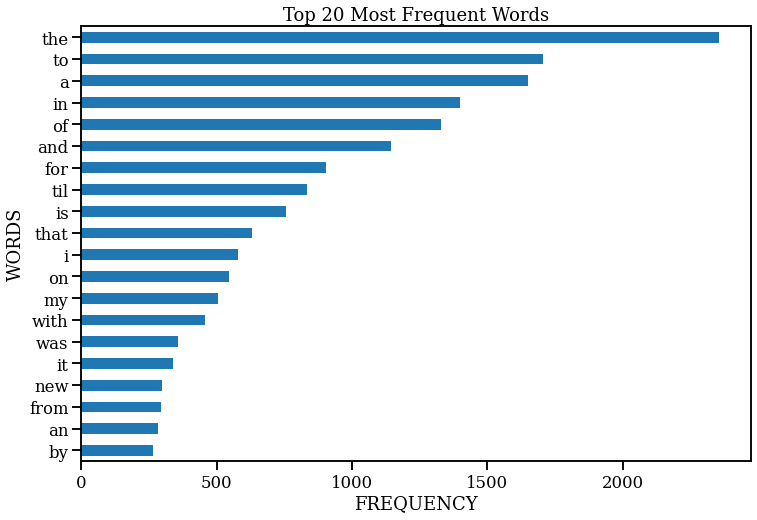

In [9]:
all_titles = ' '.join(list((clean_df['clean_title'])))
plot_ngrams(all_titles, top_n=20)

Failing to derive meaningful insights, removing stopwords (words which may carry less or no meaning such as articles, conjuctions, etc.) to identify the most common meaningful words was attempted.

### Performing ngrams (Stopwords removed)

The following cells joined the post titles into one long string, which were then be checked for the most frequently appearing words. Stopwords were removed.

The stopword set used was the union of the stopwords from sklearn and the stopwords from the NLTK corpus. This was done with the objective of removing as much interference as possible.

In [10]:
stop_words = set(stopwords.words('english'))
new_stop_words = list(set(list(stop_words) + list(ENGLISH_STOP_WORDS)))
no_stops = ' '.join([word for word in all_titles.split() if word not in new_stop_words])

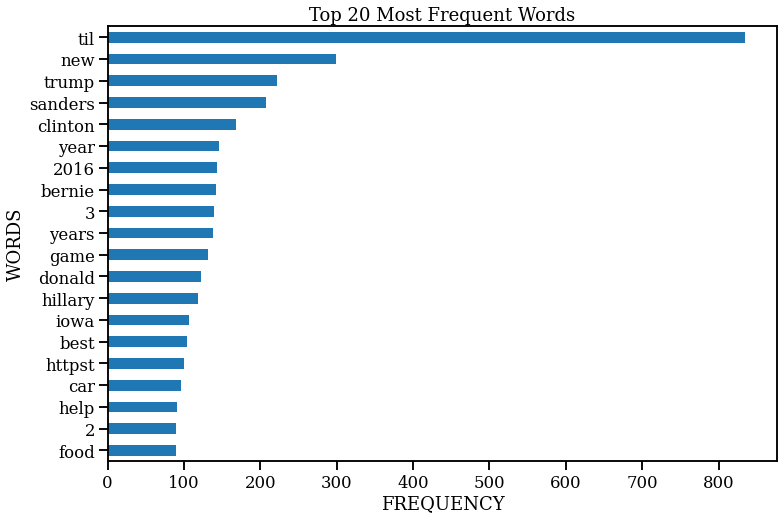

In [11]:
plot_ngrams(no_stops, top_n=20)

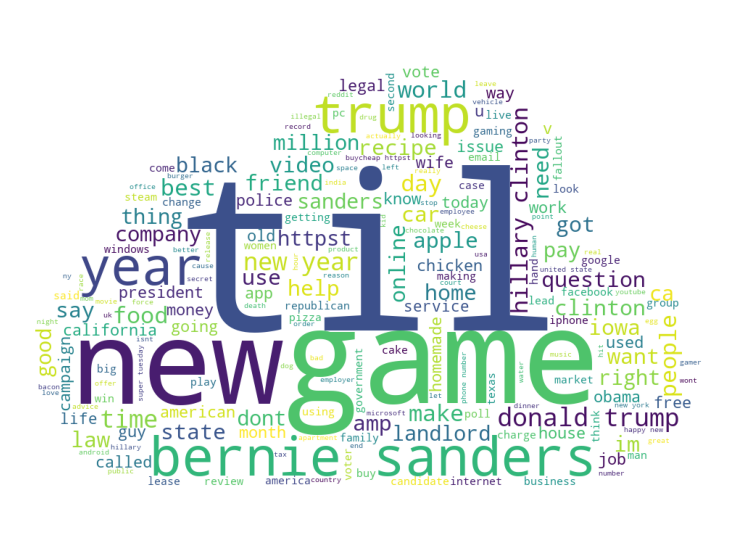

In [12]:
plt.figure(figsize=(15, 10))
plt.imshow(create_word_cloud(no_stops))
plt.axis('off')
plt.show()

#### ANALYSIS
Getting the most frequent words with the stopwords removed helped give an idea of some of the themes present in the post titles. 

Preliminary Findings:

1. TIL
    * The top word is 'til', which should actually be capitalized as 'TIL'. 'TIL' means "Today I Learned", or it is a phrase that can signify a new or amazing discovery.
    * TIL may be explored in greater depth later in this report.
2. 2016 U.S. Presidential Elections
    * The third most common word is 'trump', which is an English word, but more likely is referring to Donald Trump, the current President of the U.S., who successfully ran for office in 2016. 
    * Also present are 'sanders', and 'clinton', likely referring to Bernie Sanders and Hillary Clinton, respectively, the Democratic Party candidates for the 2016 elections.
    * The number '2016', likely referring to the year 2016, may be a nod to the elections as well.
3. Games
    * 'Game' comes out top in the word cloud, and thus is probably a popular topic.
4. New, and Year
    * The words 'new' and 'year' frequently appear. However, 'new' appears more frequently, implying that it is also used with other terms, not necessarily referring to the "New Year".

## 4. Clustering

### Rationale

* **Vectorizer** - TF-IDF vectorizer will be used to vectorize and weight terms in the corpus. According to Breitinger, Gipp, and Langer (2015), TF-IDF is one of the most popular term weighting schemes as of today.

* **Dimensionality Reduction** - Truncated SVD (TSVD) was used to reduce the dimensions of the data, decreasing runtime exponentially. Two choices are available:
    * Find the 'optimum' n where the slope of the variance explained starts decreasing drastically. 
    * Set a hard minimum cumulative variance explained at 80%.
* Since there is no reliable criterion for selecting the first option above, we will go with the second (hardline at 80%). The number of components will be chosen such the cumulative explained variance is at least 80%.

* **Clustering Method** - Rather than experimenting with various clustering methods (which was done, but is not included in this notebook), focus was given on selecting an optimum number of clusters using K-Means clustering.

* **Number of Clusters** - with the absence of external validation criteria (currently no ground truths to work with), the optimum number of clusters will be determined using Internal Validation Criteria only.

### Internal Validation Criteria

The following internal validation criteria were used on the output of the K-Means clustering.

**SSE** - this metric indicates the distances of the individual data points from their respective cluster centroids. The objective is to minimize the value of SSE, but at the same time, it is important keep the clusters parsimonious (low number of clusters). Thus, SSE represents a trade-off.

**CH** - the Calinski-Harabasz index (CH) is the ratio of the between-clusters dispersion mean and the within-cluster dispersion. For CH, larger values are desirable.

**Intra-Inter** - the ratio of the average distance of pairs $P$ that belong to the same cluster, and the average distance of pairs $Q$ that belong to different clusters. Since intra-distances are ideally less than the inter-distances, this metric should be minimized.

**Silhouette Coefficient** - let $Davg^{in}_i$ be the average distance of $x_i$ to data points within the cluster of $x_i$, and $Dmin^{out}_i$ be the smallest average distance to points other than its own cluster. The silhouette coefficient $S_i$ for the $i$th data point specific to the ith object, is as follows: 
$$
S_i = \frac{Dmin^{out}_i − Davg^{in}_i}{\max\{{Dmin^{out}_i}, Davg^{in}_i\}}
$$
The overall silhouette coefficient is the average of $S_i$.
This coefficient is best if maximized (positive).

### Vectorization

TF-IDF was used to vectorize the post titles:

In [13]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words=new_stop_words)
bow_reddit = tfidf_vectorizer.fit_transform(clean_df['clean_title'])

### Dimensionality Reduction

In performing dimensionality reduction, it is an objective to retain at least 80% cumulative variance explained. Setting `n_components` too high will result in exponentially greater runtimes, while setting `n` too low will make it less likely to deliver meaningful results. 

`n_components` set to 3000:

In [14]:
svd = TruncatedSVD(n_components=3000)
reddit_svd = svd.fit_transform(bow_reddit)

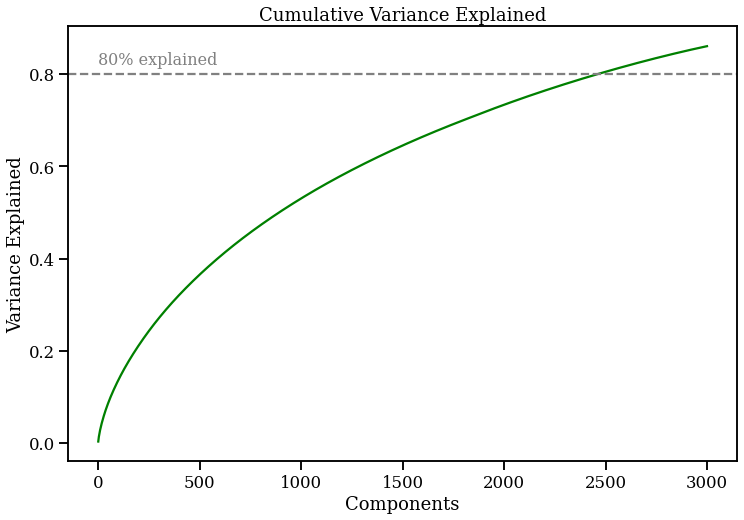

In [15]:
plt.subplots(figsize = (12,8))
plt.plot(svd.explained_variance_ratio_.cumsum(), 'g');
plt.title("Cumulative Variance Explained")
plt.xlabel('Components');
plt.ylabel('Variance Explained');
plt.axhline(0.8, color='gray', ls='--')
plt.text(0, 0.82, '80% explained', fontsize=16, color='gray')
plt.show()

#### ANALYSIS
As expected, increasing the number of components `n` leads to diminishing marginal returns as `n` grows larger. Thus, we will proceed to use Truncated SVD with $n=3000$, since this is a bit above the minimum n at which cumulative variance explained is at 80%.

TSNE was used to take a preliminary view of the data, and what the clusters might look like.

C:\ProgramData\Anaconda3\envs\standard\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\standard\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


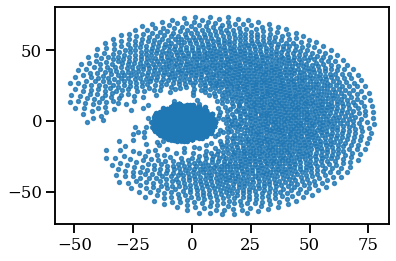

In [16]:
X_reddit_new = TSNE(random_state=1337).fit_transform(reddit_svd)
plt.scatter(X_reddit_new[:,0], X_reddit_new[:,1], s=15, alpha=0.8);

### K-means Clustering

We now proceed to K-means clustering. To facilitate this, more functions were defined in `functions.py`:
* `intra_to_inter` - since there is no built-in function to compute the Intra-Inter ratio, one was defined. 
* `cluster_range` - returns cluster labels and internal validation values for all k in the specified range.
* `plot_internal` - plots the internal validation criteria.
* `plot_clusters` - plots clusters given the design matrix and cluster labels.

Document strings were provided for each of the functions.

The following code ran `cluster_range` on the TSVD-transformed vectorized data, using K-Means. A `random_state` was chosen in order to ensure consistency of the code across runs.

In [18]:
res_reddit = cluster_range(reddit_svd, KMeans(random_state=1337), 2, 20)

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!
Clustering with k = 11... Done!
Clustering with k = 12... Done!
Clustering with k = 13... Done!
Clustering with k = 14... Done!
Clustering with k = 15... Done!
Clustering with k = 16... Done!
Clustering with k = 17... Done!
Clustering with k = 18... Done!
Clustering with k = 19... Done!
Clustering with k = 20... Done!


Plotting the clusters:

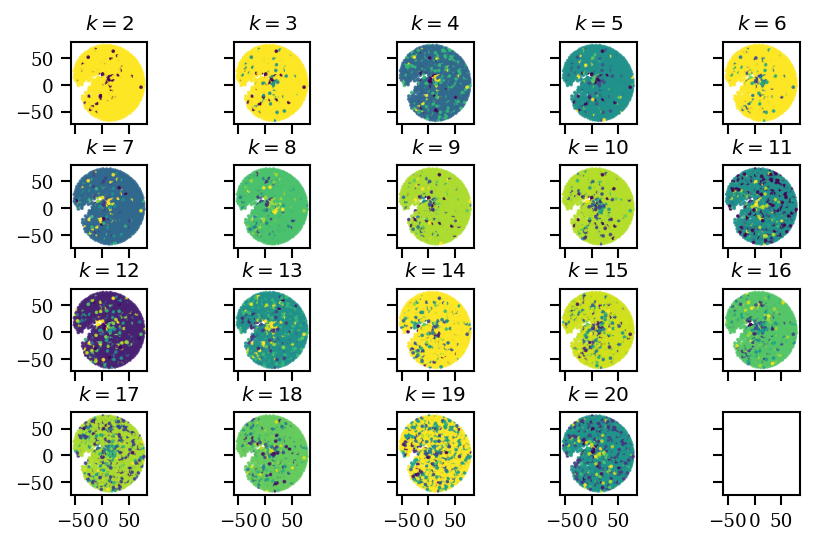

In [19]:
sns.set_context("paper")
plot_clusters(X_reddit_new, res_reddit['ys']);
sns.set_context("talk")

#### ANALYSIS
By visual inspection, the clustering appears to have performed very poorly. The reason for this is that the clustering uses 3000 features as its basis, while TSNE visualizes the 3000-feature data in a 2-dimensional space. Thus, visual inspection on results on TSNE was discounted as a criterion for choosing the number of clusters.

The internal validation criteria were plotted below to help facilitate the choice of `k`.

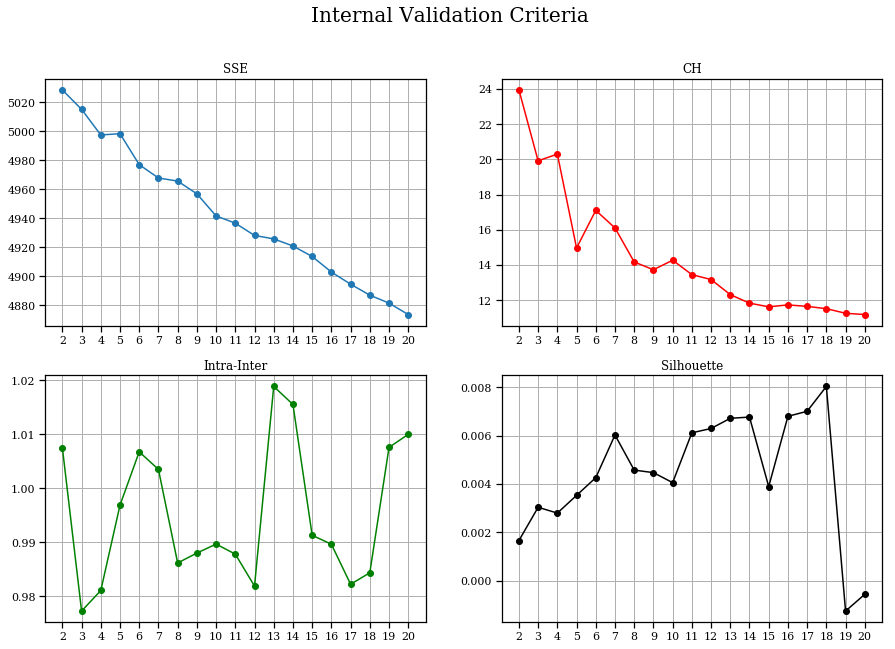

In [80]:
sns.set_context('notebook')
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle("Internal Validation Criteria", fontsize=20)

ax[0][0].plot(np.arange(2, len(res_reddit['inertias'])+2), res_reddit['inertias'], 'o-')
ax[0][0].set_xticks(np.arange(2, len(res_reddit['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()

ax[0][1].plot(np.arange(2, len(res_reddit['chs'])+2), res_reddit['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_reddit['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()

ax[1][0].plot(np.arange(2, len(res_reddit['iidrs'])+2), res_reddit['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_reddit['iidrs'])+2))
ax[1][0].set_title("Intra-Inter")
ax[1][0].grid()

ax[1][1].plot(np.arange(2, len(res_reddit['scs'])+2), res_reddit['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_reddit['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()

plt.show()

#### ANALYSIS

* **SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. However, `k` cannot simply be increased indefinitely since the clustering will no longer be parsimonious (low number of k) and the clusters might not make sense. Thus, <b>4</b> clusters might be selected since it is a local minimum. Or, if a higher number of clusters can be forgiven, it might make sense to select a k of <b>7</b> or <b>10</b> since these are also local minima. 

* **CH** - for Calinski-Harabasz index (CH), larger values are desirable. Thus, based on the plot above, <b>4, 6, 7, or 10</b> clusters might be selected since they are local maxima.

* **Inter-Intra** - A lower value of inter-intra is preferable. However, looking at the plot, there is no clear trend emerging yet at k = 2 to k = 20. This, <b>3, 4, or 8</b> clusters might be selected as they are local minima.

* **Silhouette** - This coefficient is best if maximized. Although the variations are small (they seem large in the plot due to the y-axis limits), if it is desired to keep the clusters parsimonious, then we <b>7</b> clusters might be optimal.

#### VERDICT
Based on the criteria above, pick <b>7</b> clusters and examine the output. 7 clusters were taken instead of 4 because the latter might be too few to capture more of the possible topics. If unsatisfied, try another number of clusters, in the following order:
* 10
* 8
* 6

### Round 1: K = 7

Using K means with n_clusters = 7, the output was visualized once again using TSNE.

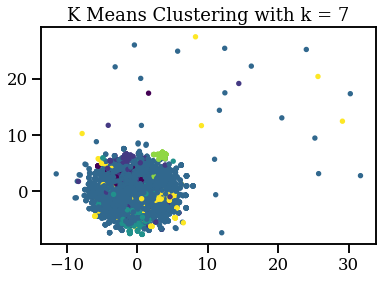

Number of members in cluster 3: 5058
Number of members in cluster 2: 236
Number of members in cluster 7: 270
Number of members in cluster 1: 64
Number of members in cluster 4: 217
Number of members in cluster 6: 60
Number of members in cluster 5: 24


In [105]:
produce_kmeans_cluster(7)

#### ANALYSIS
From looking at the TSNE visualization, it can be seen that the clustering assigned most of the members to cluster 3 (teal cluster above). However, before discounting this clustering and trying other values of `k`, it might be helpful to look at the clusters formed.

The targets were assigned, as identified by K-Means to the DataFrame `clean_df`:

In [106]:
clean_df.head()

author                                              title  \
0  PrimotechInc        7 Interesting Hidden Features of apple ios9   
1    xvagabondx                    Need an advice on gaming laptop   
2  nkindustries  Semi automatic ROPP Capping machine / ROPP Cap...   
3     Philo1927  Microsoft Plumbs Ocean’s Depths to Test Underw...   
4    tuyetnt171                OPPO F1 chính hãng - Fptshop.com.vn   

                                         clean_title lang  kmeans_7  \
0        7 interesting hidden features of apple ios9   en         2   
1                    need an advice on gaming laptop   en         2   
2  semi automatic ropp capping machine  ropp cap ...   it         2   
3  microsoft plumbs oceans depths to test underwa...   en         2   
4                   oppo f1 chnh hng  fptshop com vn   en         2   

   kmeans_10  kmeans_9  kmeans_8  
0          6         3         1  
1          6         3         0  
2          6         3         1  
3          6         1         1  
4          6         3         1

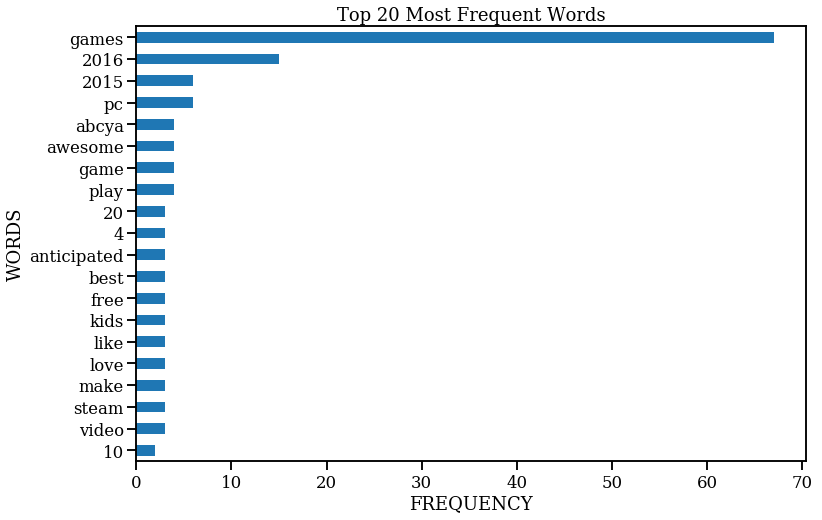

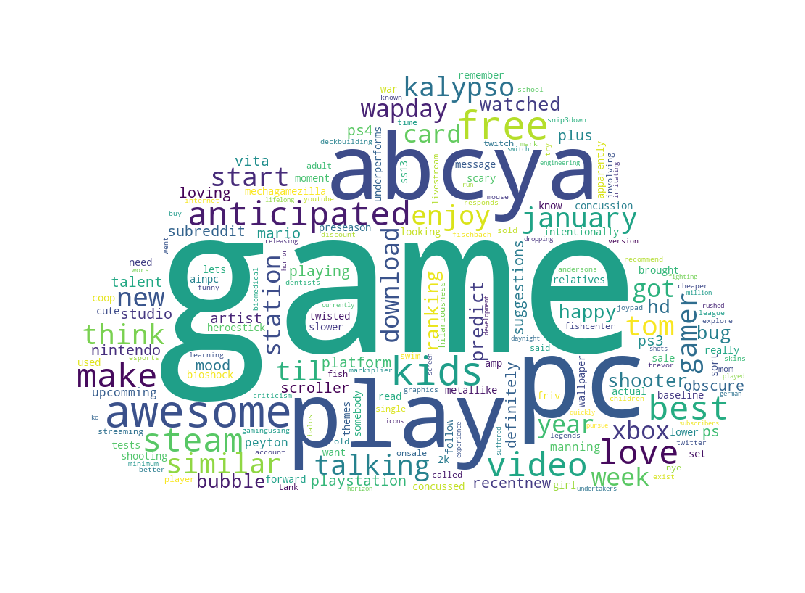

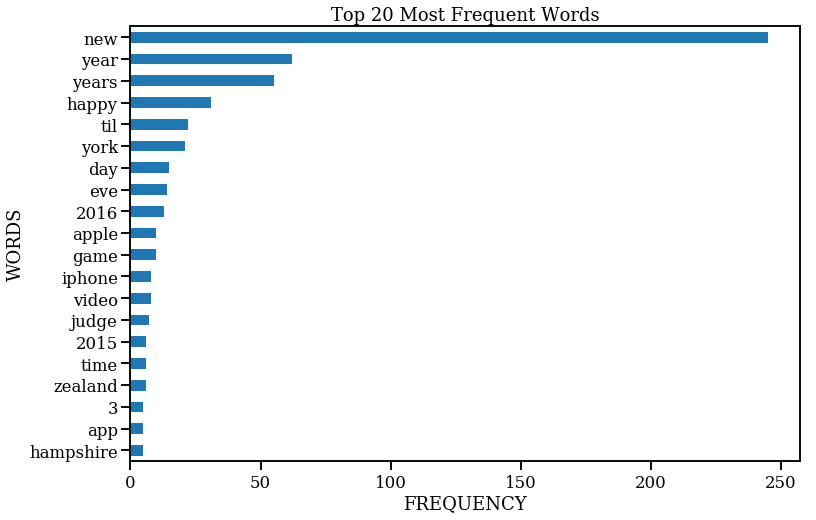

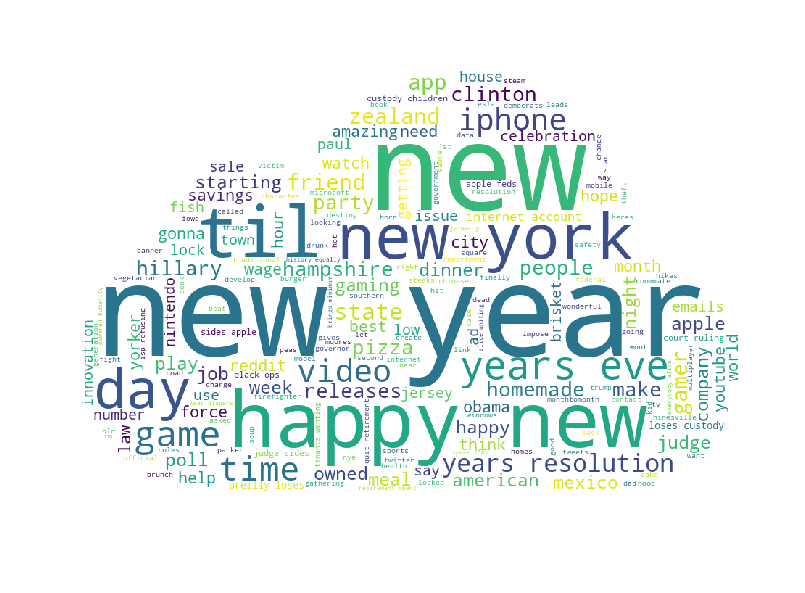

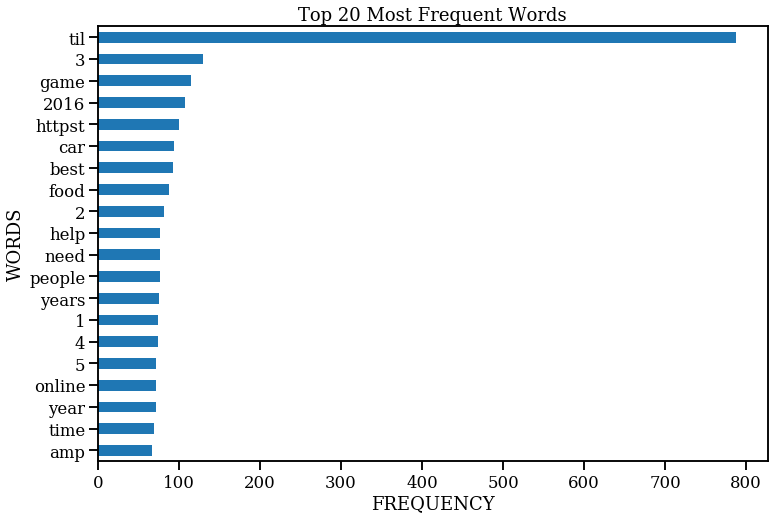

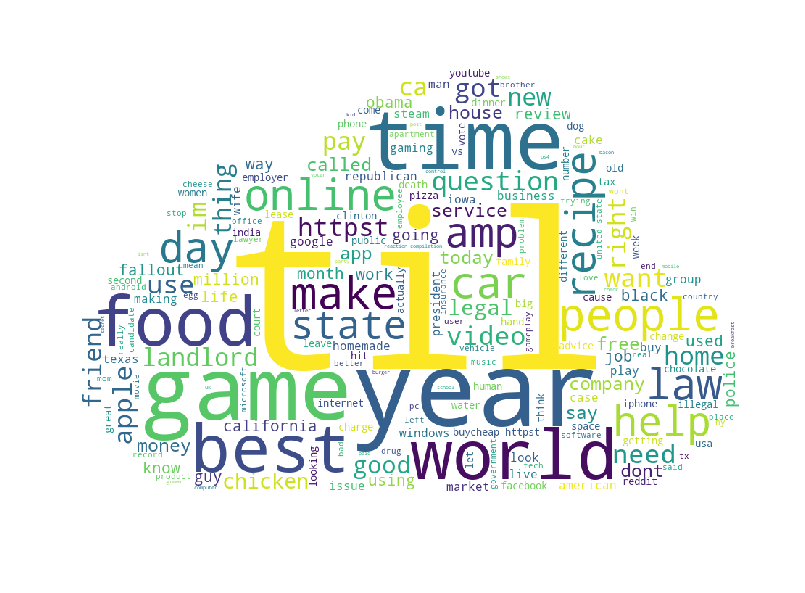

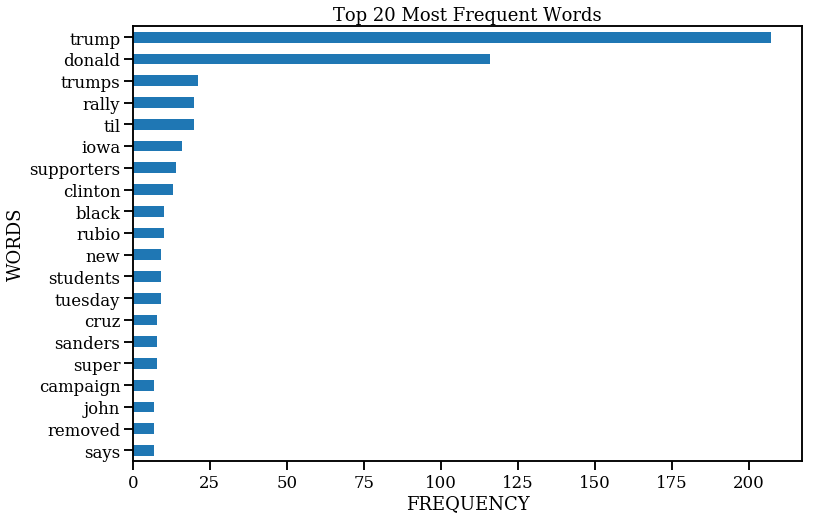

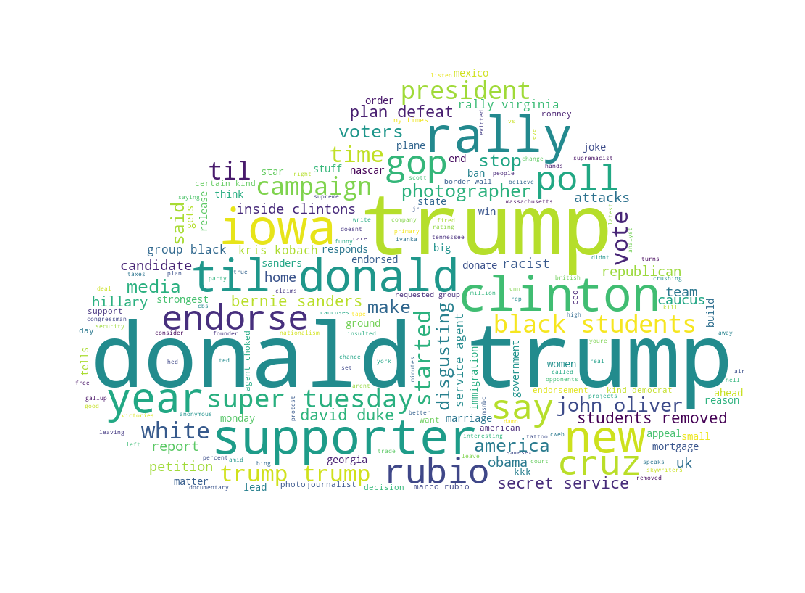

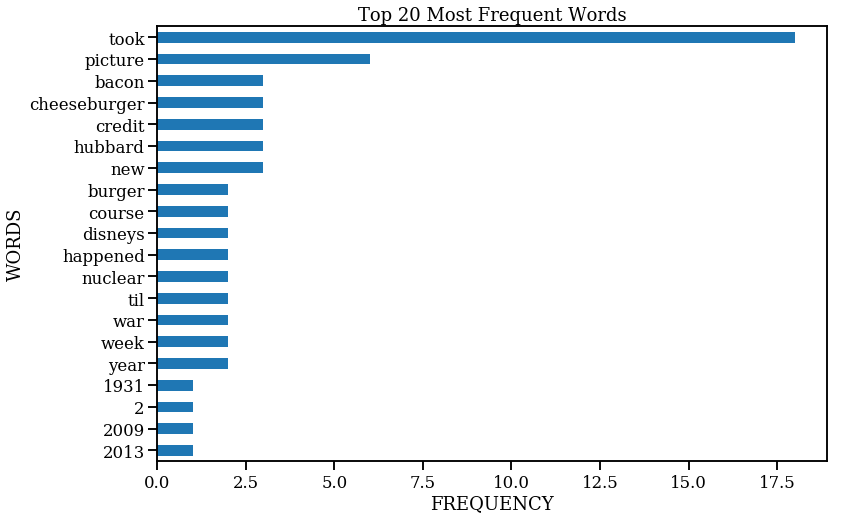

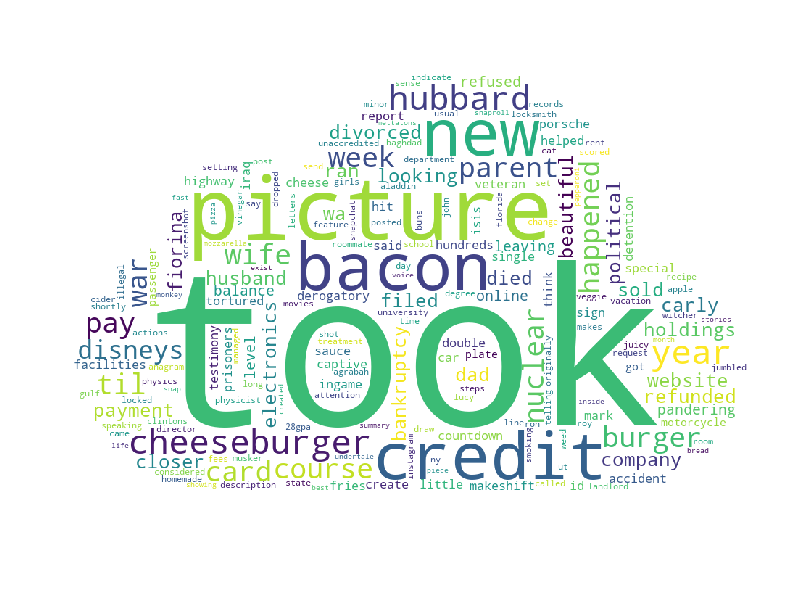

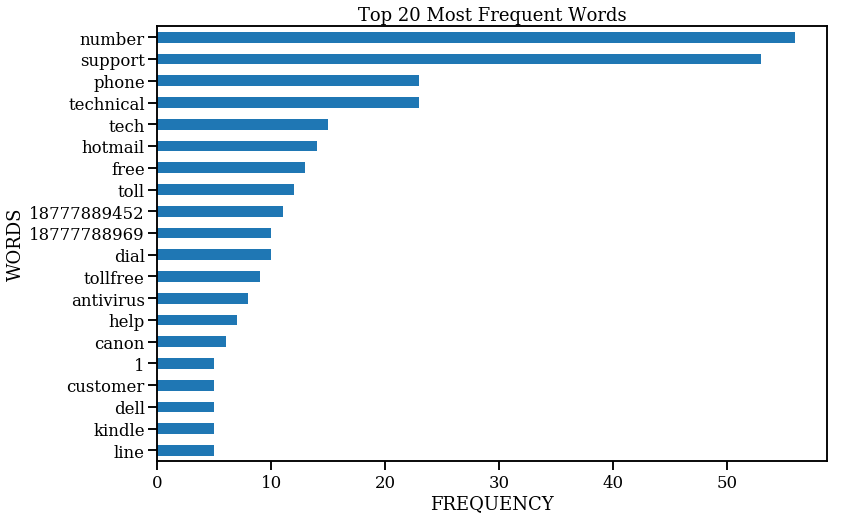

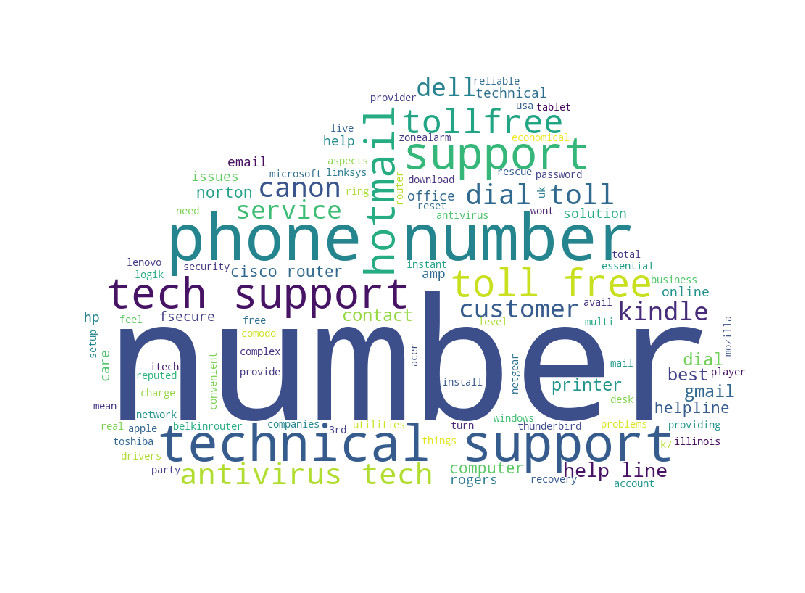

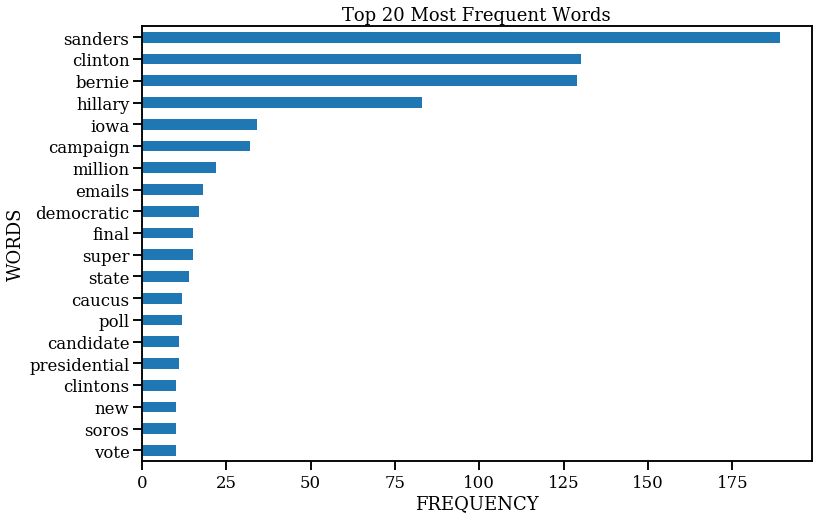

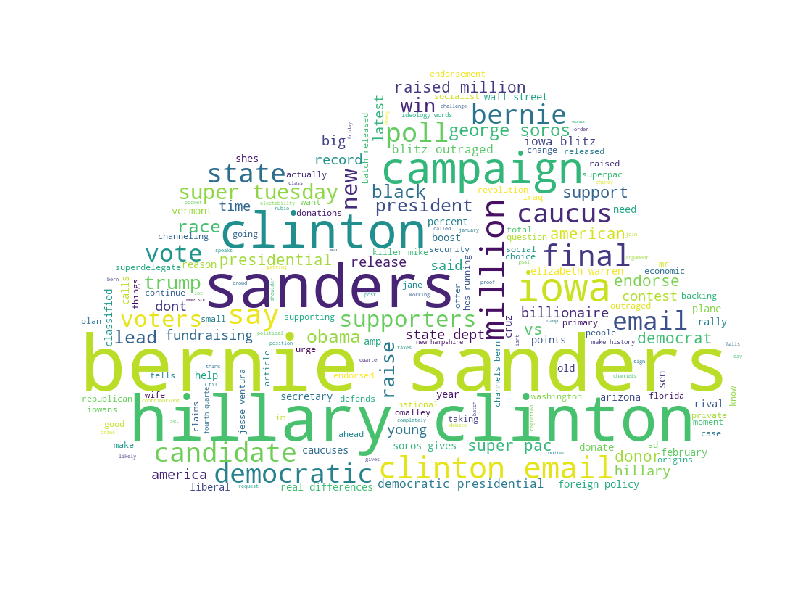

In [107]:
illustrate_clusters(clean_df, 7)

#### ANALYSIS
A subjective interpretation of the clusters that were formed at k = 7 is:
* Cluster 1: Games
* Cluster 2: New Year
* Cluster 3: TIL
* Cluster 4: Trump
* Cluster 5: *ambiguous*
* Cluster 6: Tech Support
* Cluster 7: U.S. Democrats (Clinton and Sanders)

Since many possible clusters were not captured by k = 7, and due to the fact that subjectively, this clustering may be unsatisfactory. The next round of clustering will see `k` set to 10.

### Round 2: K = 10

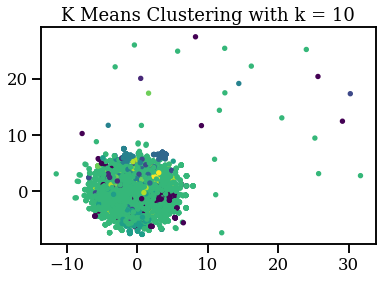

Number of members in cluster 7: 4867
Number of members in cluster 3: 89
Number of members in cluster 1: 274
Number of members in cluster 4: 126
Number of members in cluster 8: 60
Number of members in cluster 6: 218
Number of members in cluster 9: 99
Number of members in cluster 5: 138
Number of members in cluster 10: 27
Number of members in cluster 2: 31


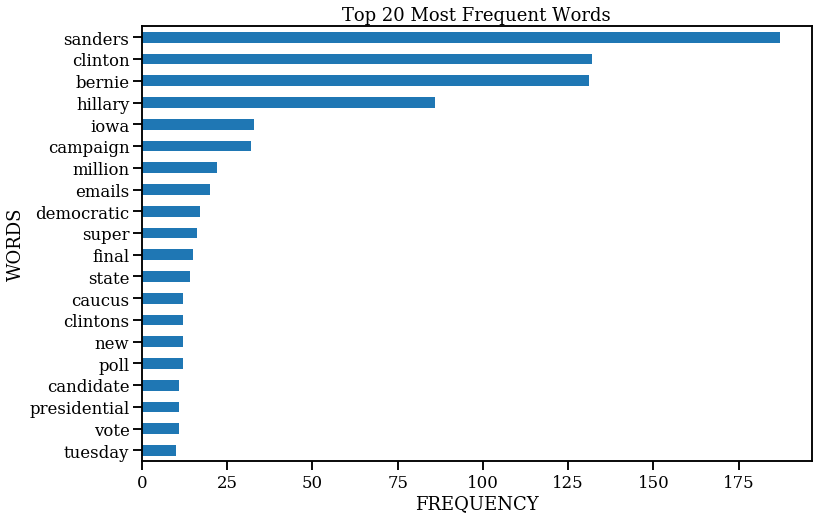

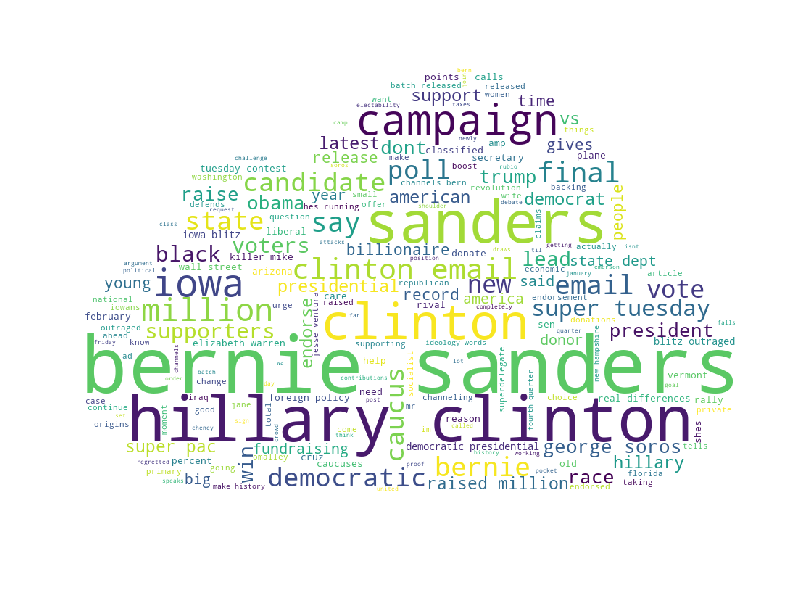

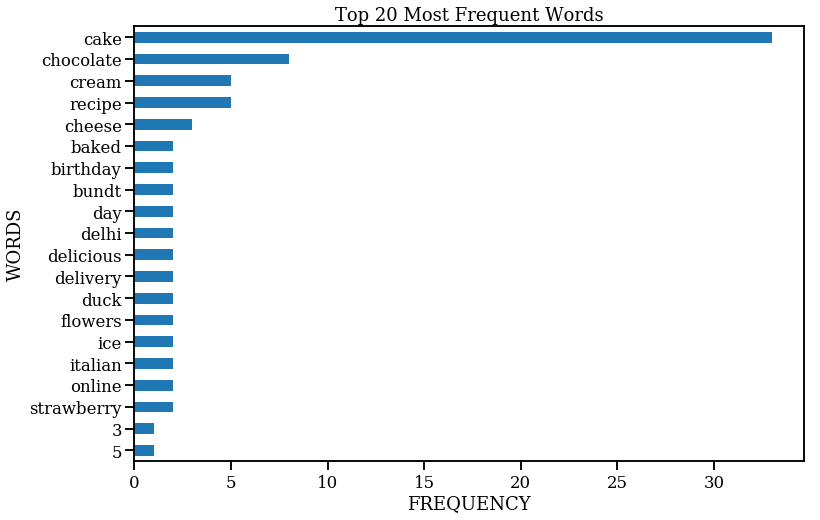

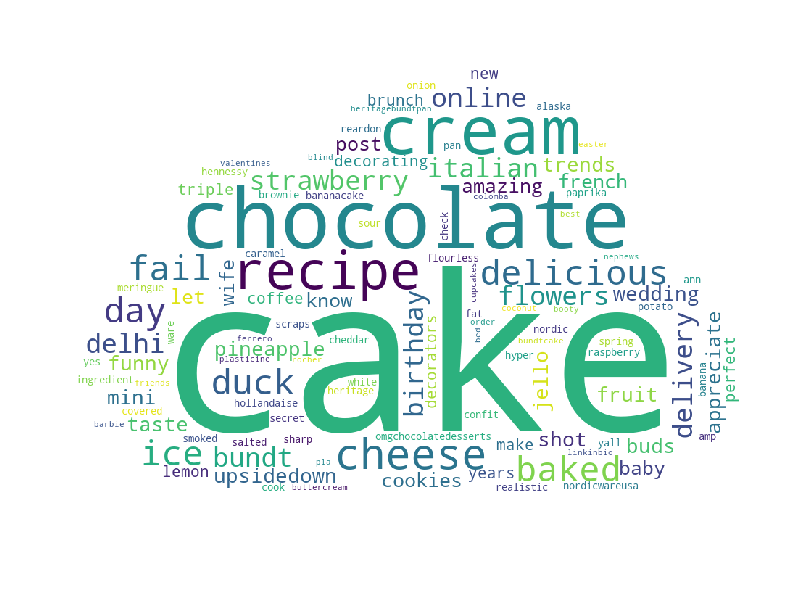

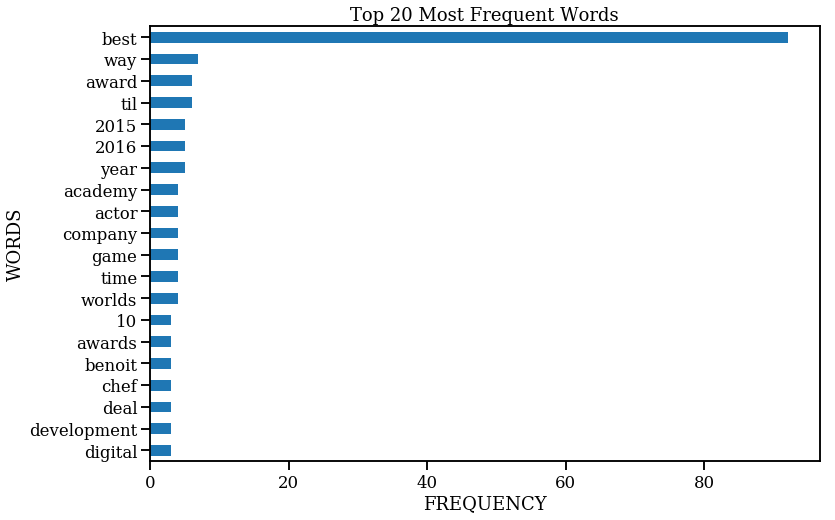

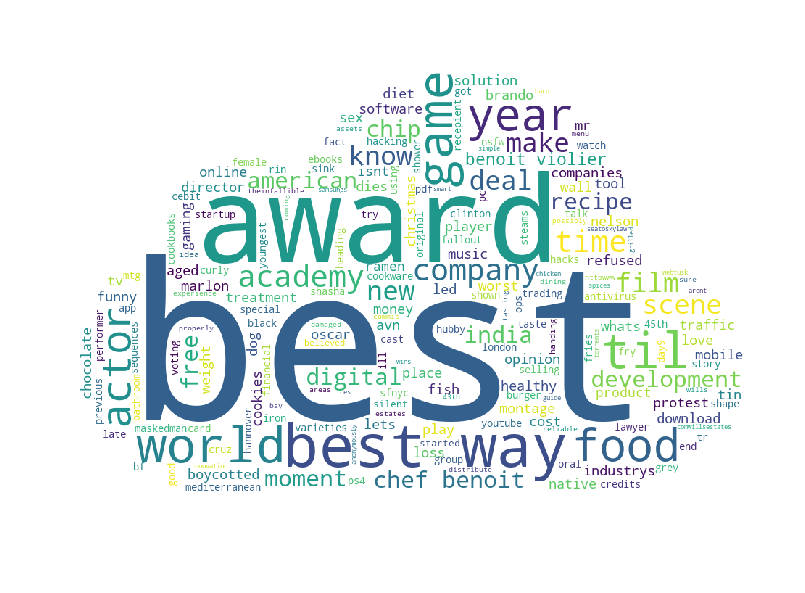

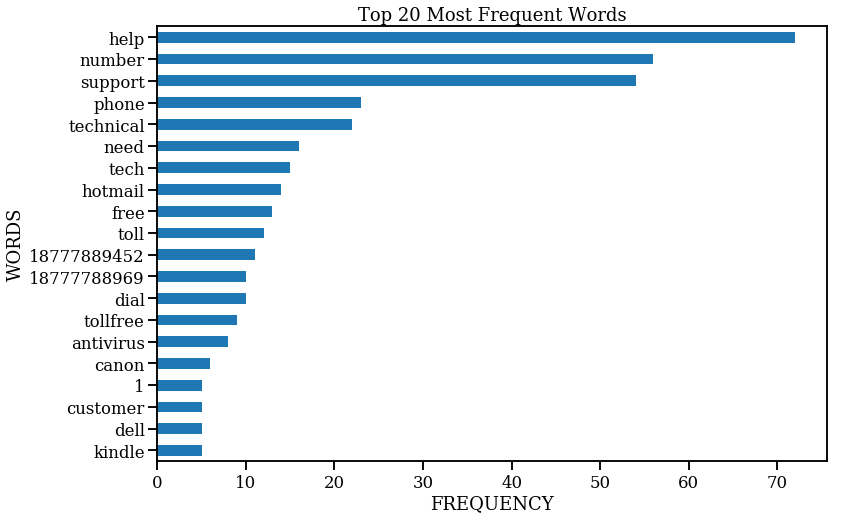

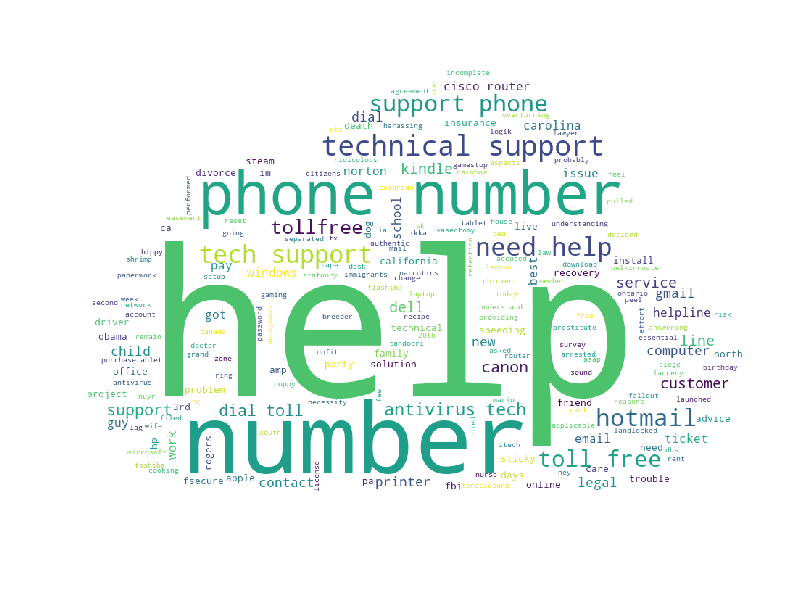

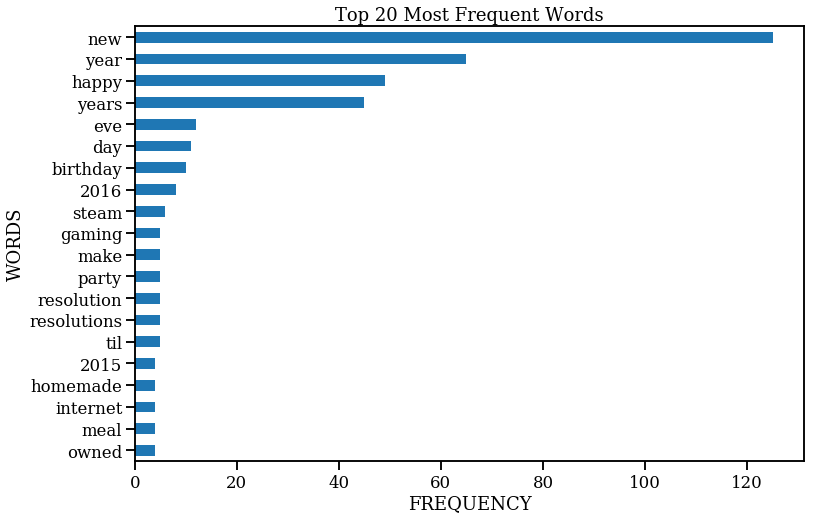

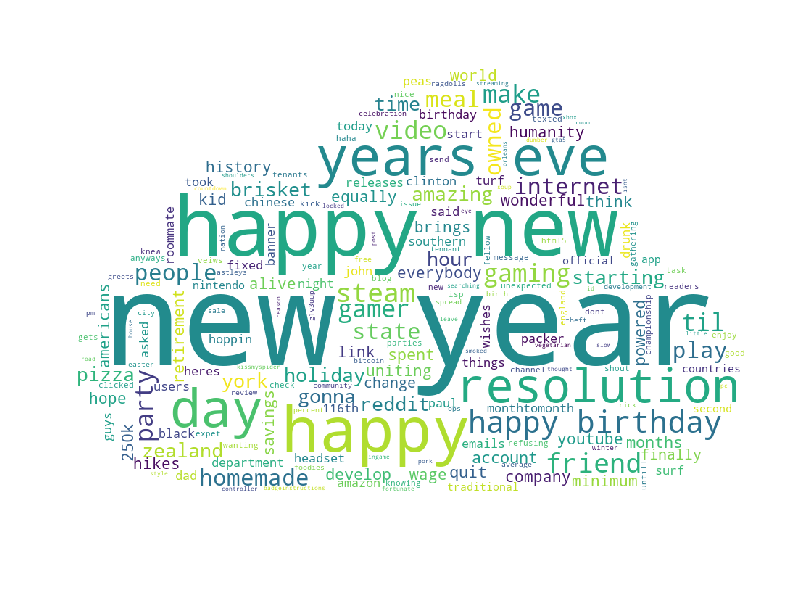

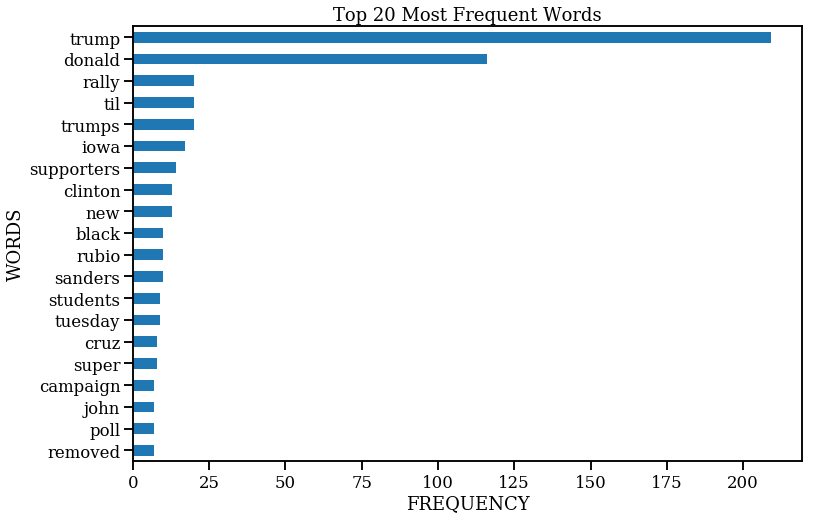

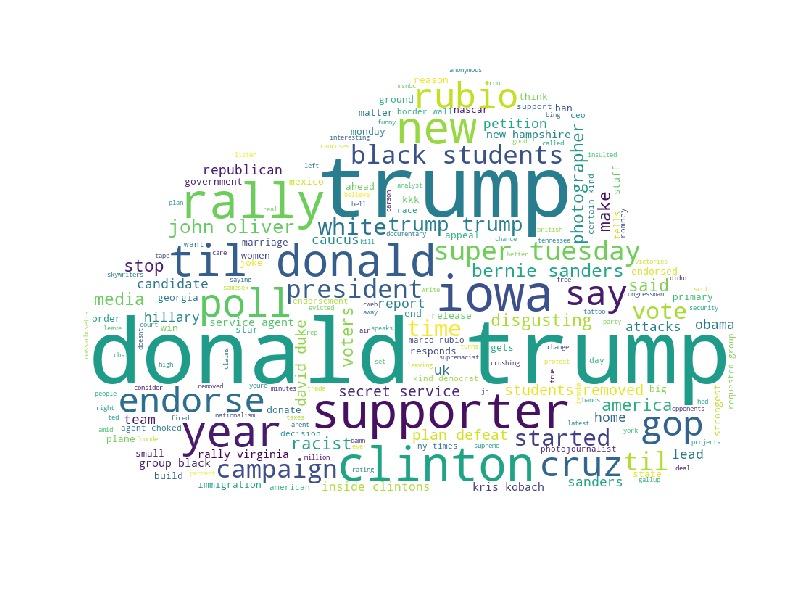

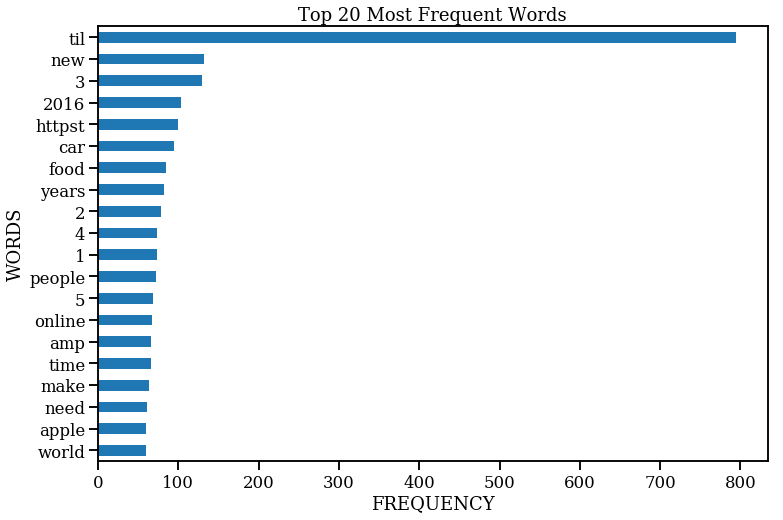

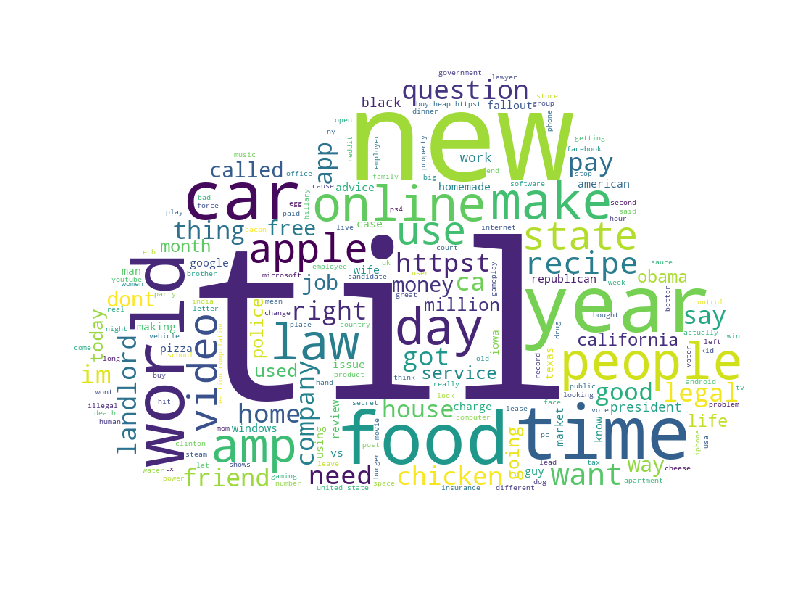

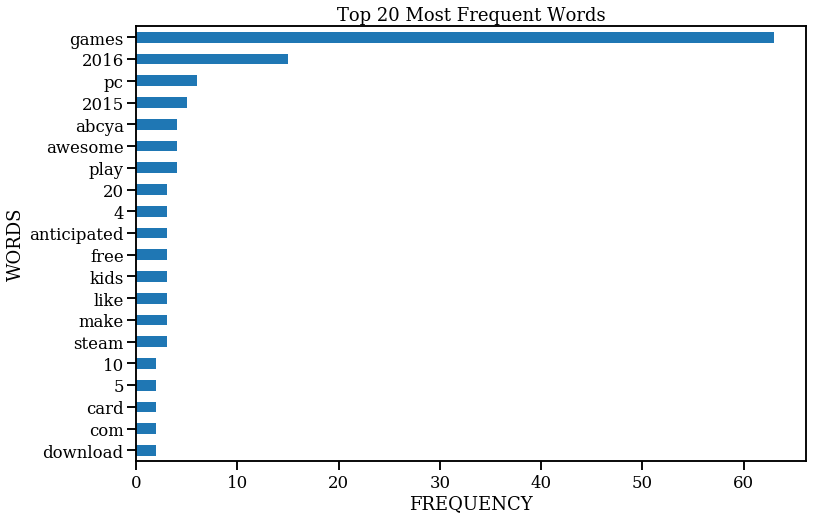

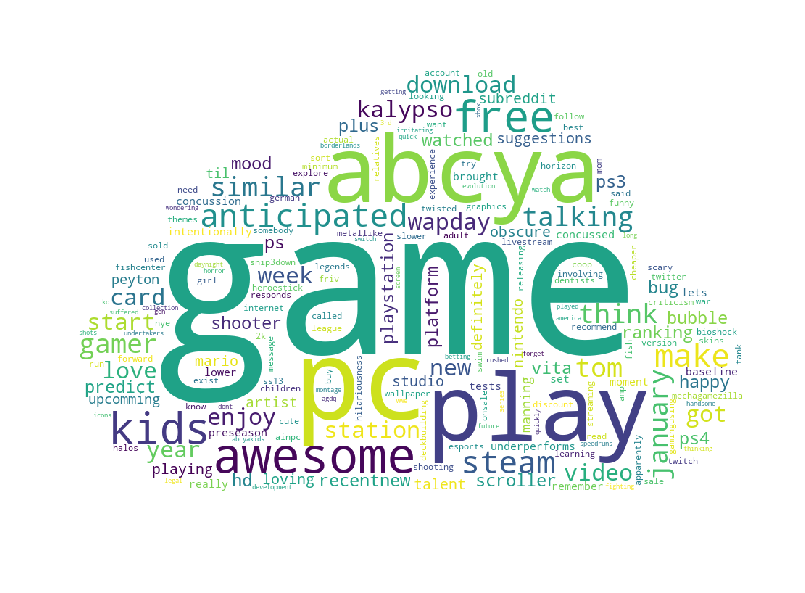

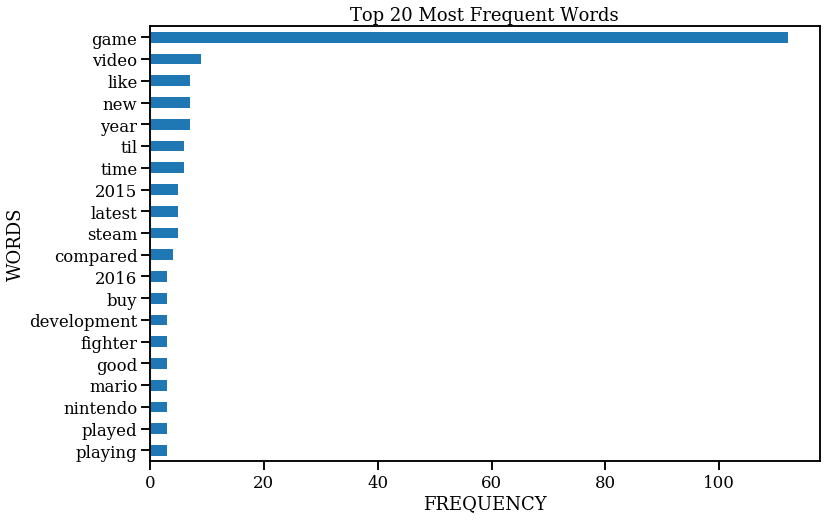

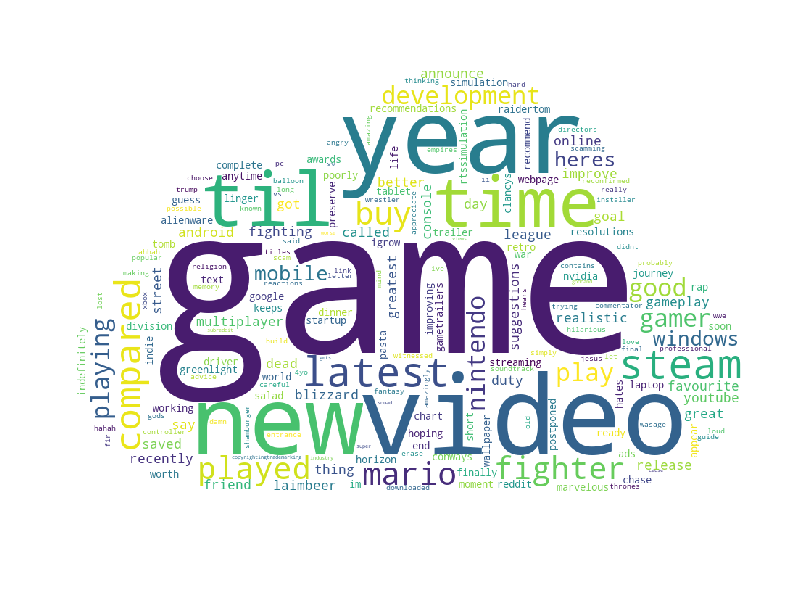

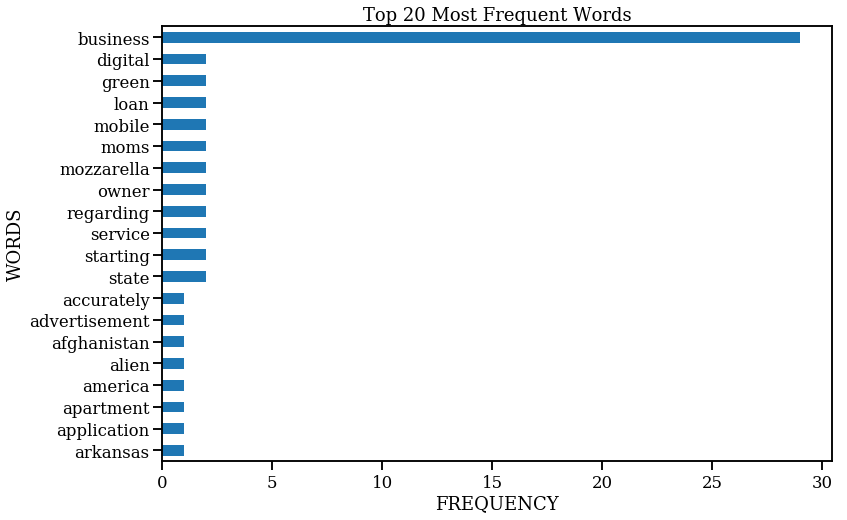

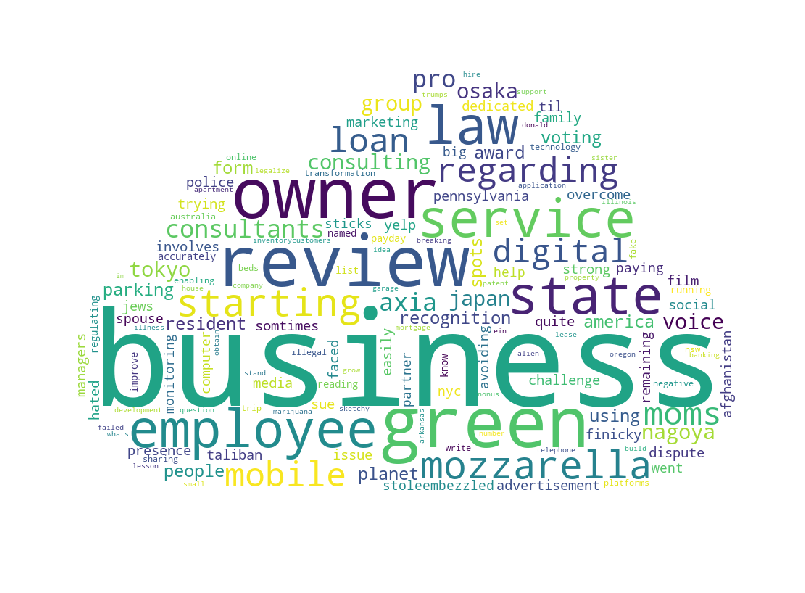

In [109]:
produce_kmeans_cluster(10)
illustrate_clusters(clean_df, 10)

#### ANALYSIS
A subjective interpretation of the clusters that were formed at k = 10 is:

* Cluster 1: U.S. Democrats (Clinton and Sanders)*
* Cluster 2: Baking and Recipes
* Cluster 3: Awards
* Cluster 4: Tech Support*
* Cluster 5: New Year*
* Cluster 6: Trump*
* Cluster 7: TIL*
* Cluster 8: Games*
* Cluster 9: Games
* Cluster 10: Business

\*Clusters that have appeared previously are marked with an asterisk. With this, we are implying that these are more likely to be actual clusters.

More potential clusters were captured upon setting k = 10, but with the side effect of two clusters about games. Thus, simply increasing `k` might not always give the best results.

### Final Round: K = 8

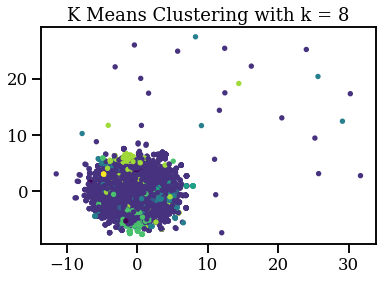

Number of members in cluster 2: 5046
Number of members in cluster 1: 33
Number of members in cluster 7: 212
Number of members in cluster 4: 274
Number of members in cluster 3: 70
Number of members in cluster 6: 220
Number of members in cluster 5: 42
Number of members in cluster 8: 32


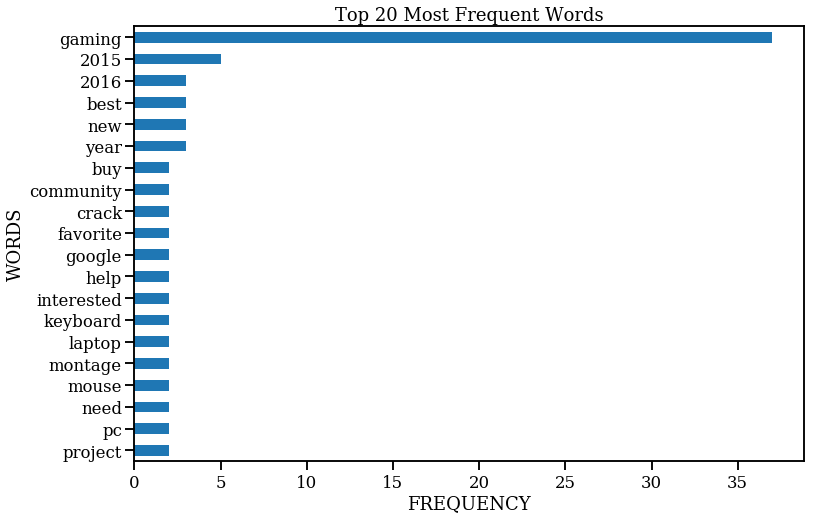

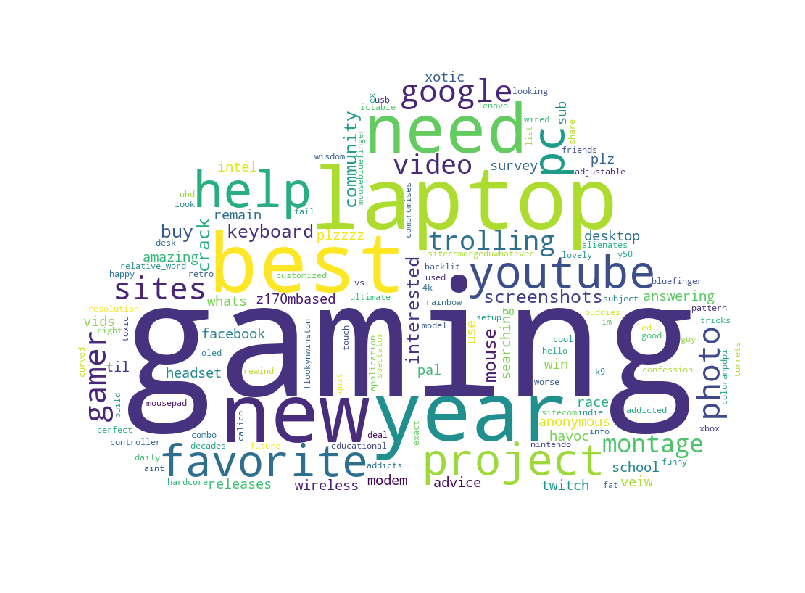

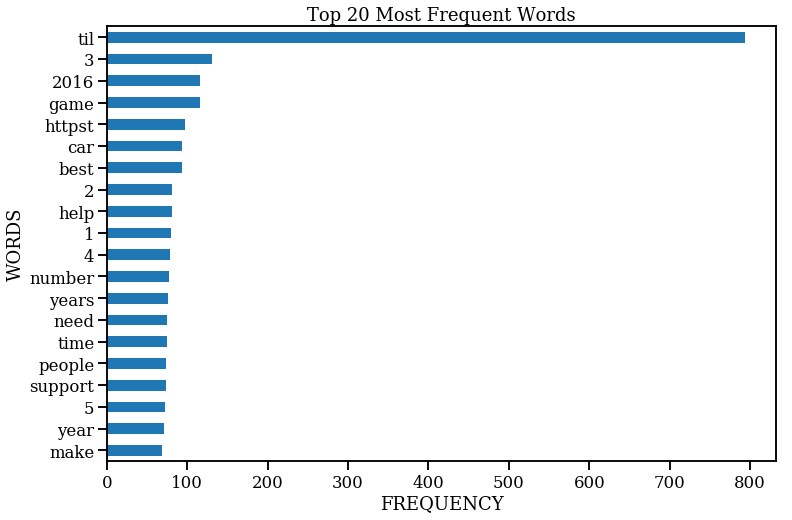

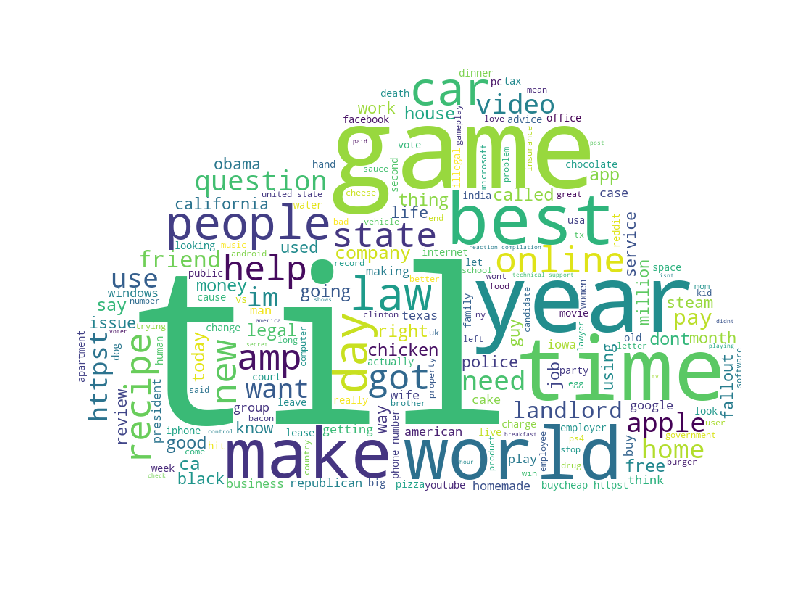

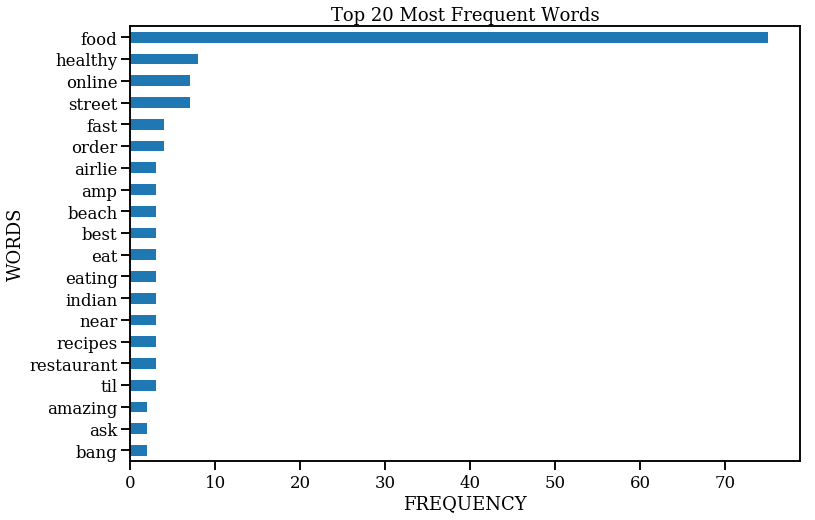

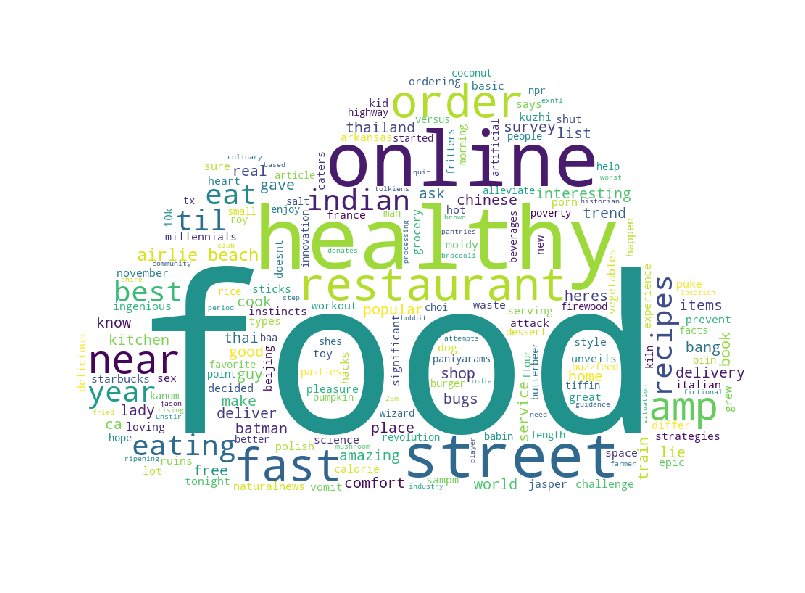

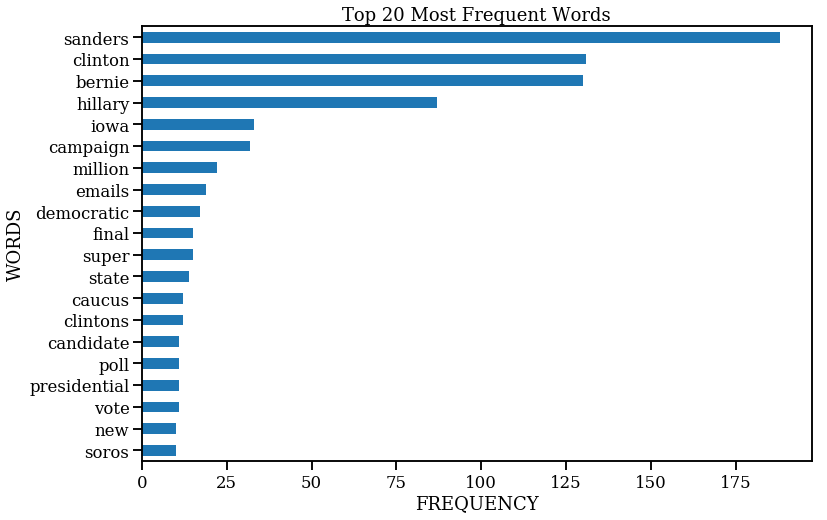

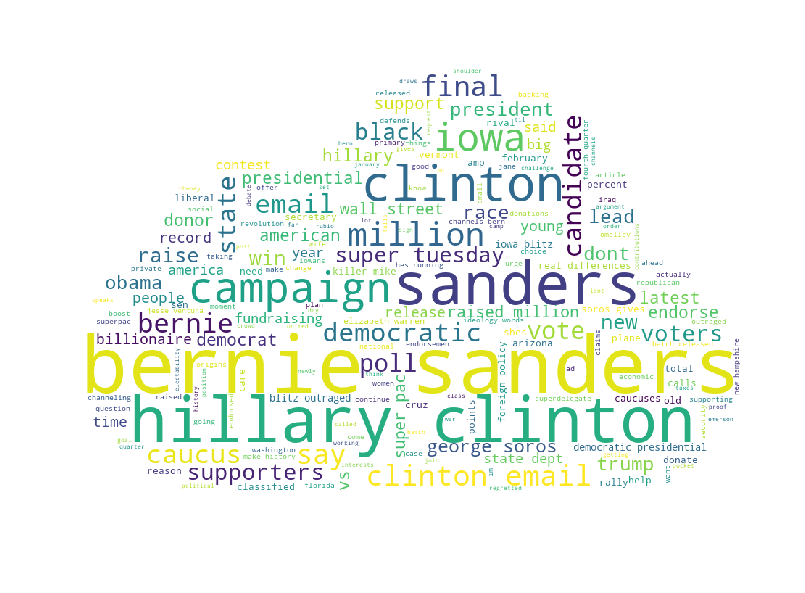

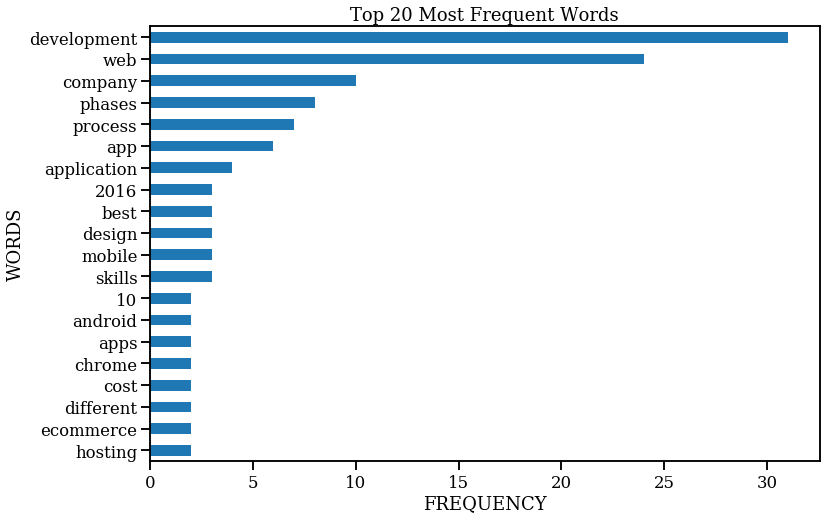

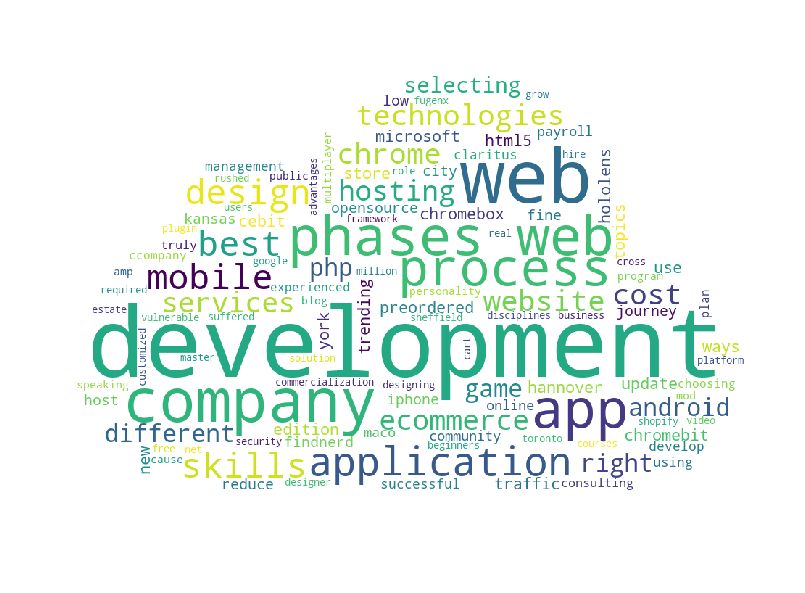

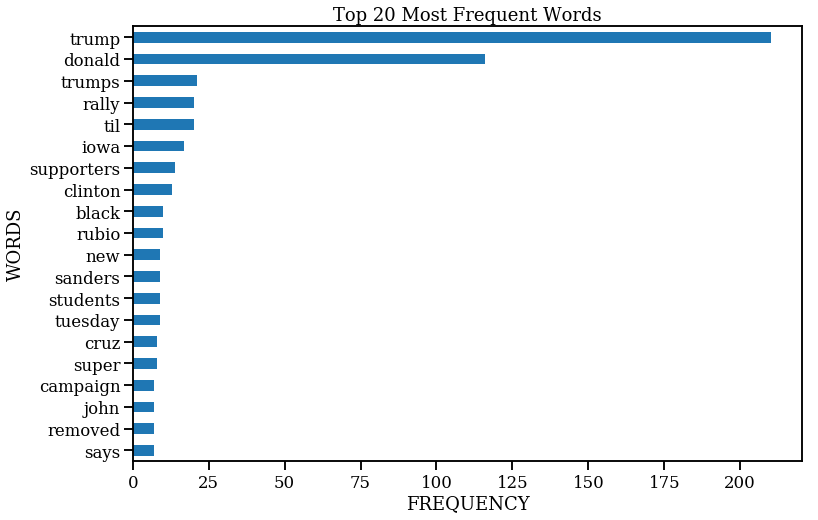

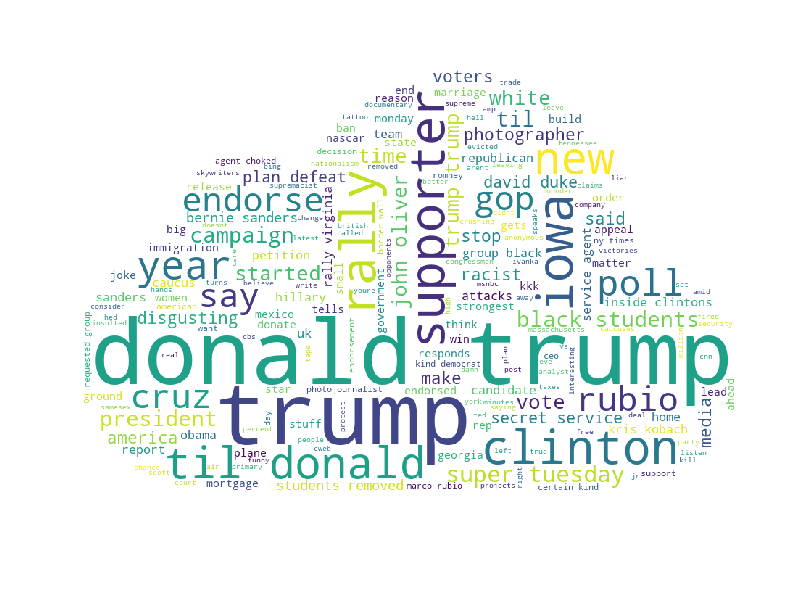

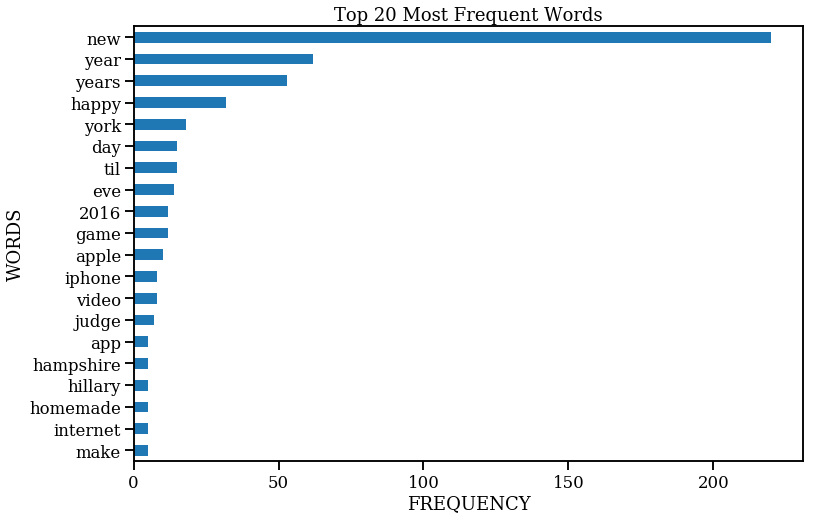

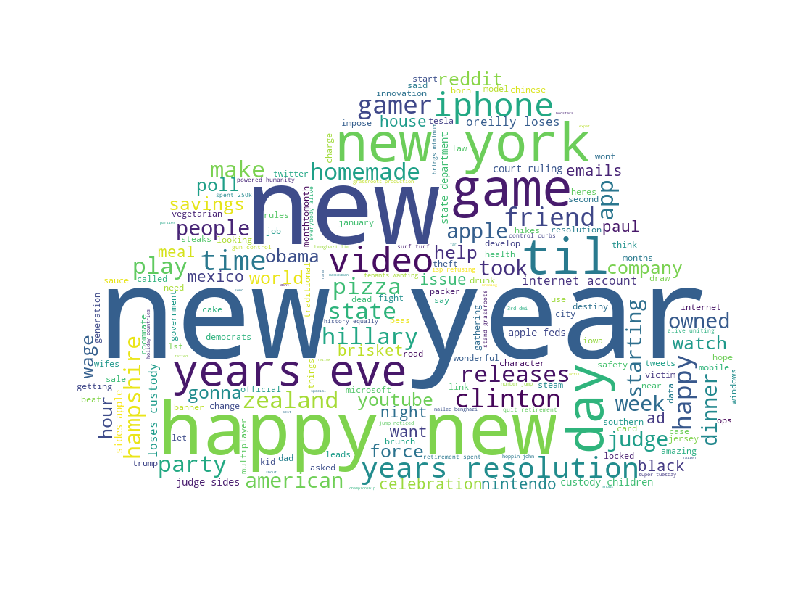

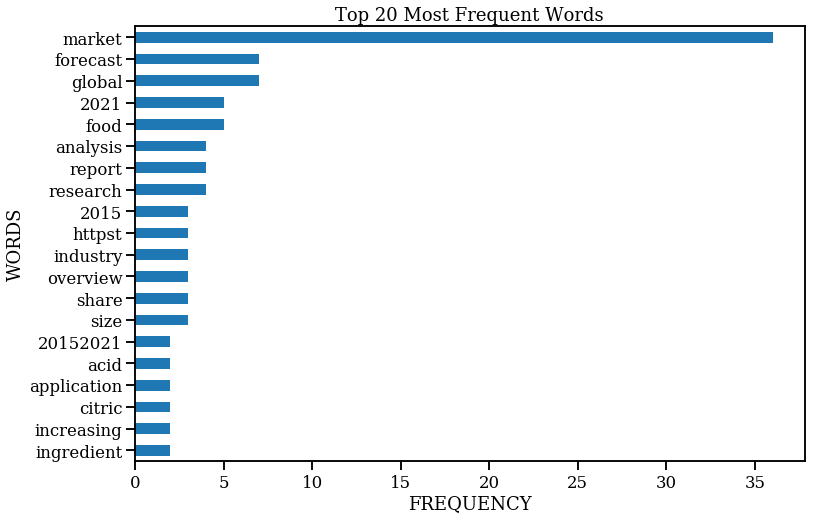

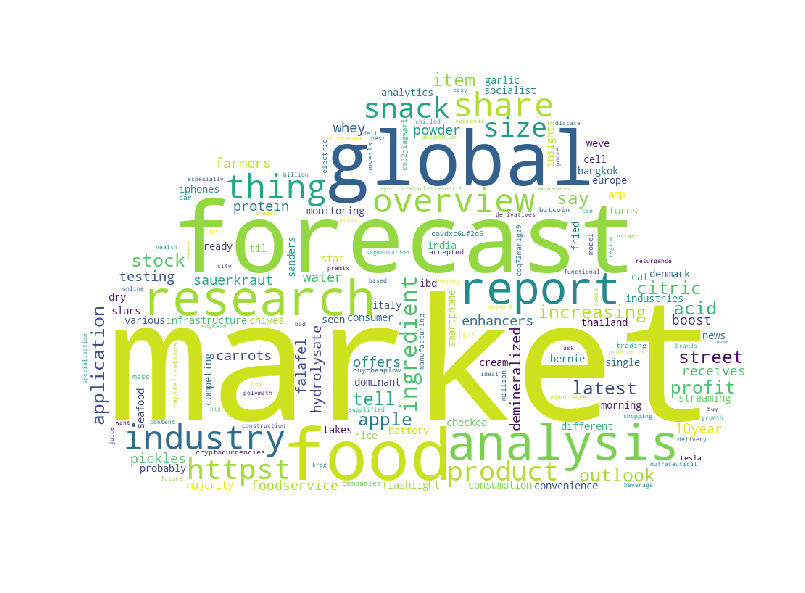

In [108]:
produce_kmeans_cluster(8)
illustrate_clusters(clean_df, 8)

#### ANALYSIS
A subjective interpretation of the clusters that were formed at k = 8 is:
* Cluster 1: Games*
* Cluster 2: TIL*
* Cluster 3: Food
* Cluster 4: U.S. Democrats (Clinton and Sanders)*
* Cluster 5: Web Development
* Cluster 6: Trump*
* Cluster 7: New Year*
* Cluster 8: Market

\*Clusters that have appeared previously are marked with an asterisk. With this, we are implying that these are more likely to be actual clusters.

Having reduced `k` from 10 to 8, despite the reasonable loss of some of the clusters seen earlier at k = 10, some previously unseen clusters have appeared, such as "Food" and "Web Development".

## 5. Interpretation and Conclusion

The following clusters were identified for the three values of `k` used:

<div style="width:33%; display:inline-table">
    <center><h4>7 Clusters</h4></center>
    <ul>
        <li>Cluster 1: Games***</li>
        <li>Cluster 2: New Year***</li>
        <li>Cluster 3: TIL***</li>
        <li>Cluster 4: Trump***</li>
        <li>Cluster 5: <i>ambiguous</i></li>
        <li>Cluster 6: Tech Support**</li>
        <li>Cluster 7: U.S. Democrats (Clinton and Sanders)***</li>
    </ul>
</div><div style="width:33%; display:inline-table">
    <center><h4>8 Clusters</h4></center>
    <ul>
        <li>Cluster 1: Games***</li>
        <li>Cluster 2: TIL***</li>
        <li>Cluster 3: Food*</li>
        <li>Cluster 4: U.S. Democrats (Clinton and Sanders)***</li>
        <li>Cluster 5: Web Development*</li>
        <li>Cluster 6: Trump***</li>
        <li>Cluster 7: New Year***</li>
        <li>Cluster 8: Market*</li>
    </ul>
</div><div style="width:33%; display:inline-table">
    <center><h4>10 Clusters</h4></center>
    <ul>
        <li>Cluster 1: U.S. Democrats (Clinton and Sanders)***</li>
        <li>Cluster 2: Baking and Recipes*</li>
        <li>Cluster 3: Awards*</li>
        <li>Cluster 4: Tech Support**</li>
        <li>Cluster 5: New Year***</li>
        <li>Cluster 6: Trump***</li>
        <li>Cluster 7: TIL***</li>
        <li>Cluster 8: Games***</li>
        <li>Cluster 9: (Games)***</li>
        <li>Cluster 10: Business*</li>
    </ul>
</div>

\*Clusters are marked with asterisks according to the number of times they have appeared among the three values of `k`. With this, we are implying that these are more likely to be legitimate clusters.

Summarizing the above into one list of clusters, the following guess at revealing the subreddits was made:

### Higher likelihood:

* **Cluster 1: Games** - video game discussions of existing and anticipated upcoming games. The word 'best' also cropped up, implying that people might have been suggesting games to each other. They also talked about the platforms for these games, particularly PC. 

* **Cluster 2: New Year** - mostly composed of greetings for the New Year, some stray posts were also clustered into this category due to not considering n-grams above 1.

* **Cluster 3: TIL** - discussions of new and amazing discoveries made by redditors, this cluster does not seem to gravitate towards any one theme in particular. It may be helpful to browse the appendix of this report, where clustering was done on all 'TIL' posts. However, nothing significant was gleaned from this clustering.

* **Cluster 4: Trump** - the President of the United States, Donald Trump's electoral campaign was marked by controversy. Being a right-wing populist, the notion of Trump as the US President was quite polarizing to the populace, sparking exchanges and debates online and in real life.

### High likelihood:

* **Cluster 5: U.S. Democrats** - Hillary Clinton and Bernie Sanders, the two leading candidates for the U.S. Democratic Party for their 2016 Presidential Election, were the belligerents in a particularly vicious presidential primary battle. In fact, their feud continues up to this day. The presence of this cluster, as well as the previous one (Trump), show that discussions of the American election comprise a significant portion of the sample reddit posts taken. This may imply that either a large proportion of the reddit population is American (U.S.), or the Americans discussed their election excessively.

* **Cluster 6: Tech Support** - popular words in this cluster were 'help', 'number', 'support', and 'technical', implying that this cluster included discussions where people sought redditors for help with technical problems.

### Other possible clusters:

* **Cluster 7: Food** - words appearing in this cluster include 'healthy', 'online', and 'street'. Interestingly, at higher values of `k`, such as 13 or 15 (not shown in this notebook), this cluster breaks up into subclusters, interpreted (subjectively) to be:
    * Healthy Food
    * Home-cooked Food (Recipes)
    * Restaurants/Eating Out

* **Cluster 8: Web Development** - reddit itself being a website, it might make sense for the community to discuss web development on the site. Frequently-appearing words include 'company', 'phases', and 'application'.

* **Cluster 9: Market** - frequent terms under this cluster include 'forecast' and 'global'.

* **Cluster 10: Baking and Recipes** - depending on how compact the clusters should be, this cluster might be considered a subcluster of `Food`. Terms frequently appearing include 'cake', 'chocolate', 'cream', and 'recipe', implying the sharing of recipes among redditors.

* **Cluster 11: Awards** - the most frequent term appearing in this cluster is actually 'best', but it might be more apt to name this cluster 'awards' due to the ambiguity of the former. The category of this cluster becomes more apparent when reading some of the terms which are not necessarily the most frequent, such as 'academy' and 'actor'.

* **Cluster 12: Business** - terms which naturally relate to business, such as 'loan', 'owner', 'employee', and 'law' make their appearance, but interestingly, words such as 'digital' and 'green' appear as well with a high frequency.

## 6. Acknowledgments

Special thanks to Prof. Christian Alis for the notebooks, from which I derived plenty of my code.

Thanks to my LT-mates, as well as LT 1 for some good discussions as well.

To my former LT-mate, for letting me take a look at his code for K-means clustering (there were some errors in my own notebook).

Names were not mentioned in keeping with the anonymity requirement.

## 7. References

* *Representative-based Clustering Notebook* by C. Alis / E. David, AIM (DMW Course Material)
* Breitinger, Corinna; Gipp, Bela; Langer, Stefan (2015-07-26). "Research-paper recommender systems: a literature survey". International Journal on Digital Libraries.

Websites:
* https://www.foxnews.com/politics/dems-fear-never-ending-clinton-sanders-feud-could-damage-party-in-2020-they-need-to-stop

Images retrieved from:
* https://www.redditgifts.com/exchanges/manage/#/exchange/decorate-your-cube-2019/

## 8. Appendix

### Clustering all "TIL" Posts

This section is optional, as the author does not find it to be meaningful. This clustering was relegated to the appendix because meaningful clusters failed to form with this analysis.

In [149]:
clean_df1 = clean_df[clean_df['clean_title']\
                     .str.startswith('til')][['author', 'clean_title']]
clean_df2 = clean_df[~clean_df['clean_title']\
                     .str.startswith('til')][['author', 'clean_title']]

print("TIL DataFrame")
print("-------------")
print("\nBEFORE:")
display(clean_df1.head())
clean_df1['no_til_title'] = clean_df1['clean_title'].apply(remove_til)
print("\nAFTER ('TIL' removed):")
display(clean_df1.head())

TIL DataFrame
-------------

BEFORE:


author                                        clean_title
10     [deleted]  til maternal kisses are not effective in allev...
22     [deleted]  til goldman sachs did a study in 2009 that est...
31  MattValentin  til the justice leagues martian manhunter was ...
38    scotchleaf  til that the top 25 hedge fund managers in the...
47     [deleted]  til leonard howell the first rasta preached th...


AFTER ('TIL' removed):


author                                        clean_title  \
10     [deleted]  til maternal kisses are not effective in allev...   
22     [deleted]  til goldman sachs did a study in 2009 that est...   
31  MattValentin  til the justice leagues martian manhunter was ...   
38    scotchleaf  til that the top 25 hedge fund managers in the...   
47     [deleted]  til leonard howell the first rasta preached th...   

                                         no_til_title  
10  maternal kisses are not effective in alleviati...  
22  goldman sachs did a study in 2009 that estimat...  
31  the justice leagues martian manhunter was once...  
38  that the top 25 hedge fund managers in the us ...  
47  leonard howell the first rasta preached that r...

### Vectorization

Using tfidf to vectorize the post titles:

In [111]:
tfidf_vectorizer_til = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words=new_stop_words)
bow_til = tfidf_vectorizer_til.fit_transform(clean_df1['no_til_title'])

### Dimensionality Reduction

In [112]:
bow_til.shape

(830, 4723)

In [113]:
svd_til = TruncatedSVD(n_components=829)
til_svd = svd_til.fit_transform(bow_til)

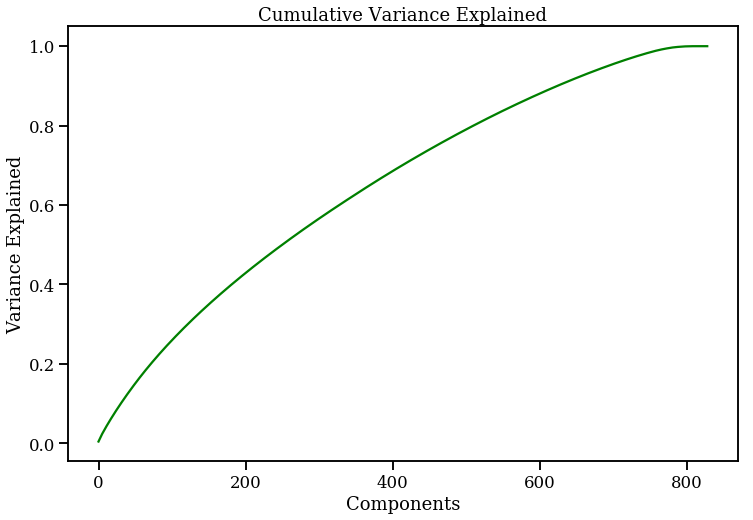

In [114]:
plt.subplots(figsize = (12,8))
plt.plot(svd_til.explained_variance_ratio_.cumsum(), 'g');
plt.title("Cumulative Variance Explained")
plt.xlabel('Components');
plt.ylabel('Variance Explained');
plt.show()

In [115]:
svd_til = TruncatedSVD(n_components=500)
til_svd = svd_til.fit_transform(bow_til)

#### ANALYSIS
As expected, increasing the number of components `n` leads to diminishing marginal returns as `n` grows larger. We have two choices here:

* Find the 'optimum' n where the slope of the variance explained starts decreasing drastically. 
* Set a hard minimum cumulative variance explained at 80%.

Since we do not have reliable criteria for selecting the first option, we will go with the second (hardline at 80%). Thus, use Truncated SVD with $n=2500$, since this is a bit above the minimum n at which cumulative variance explained is at 80%.

Let's use TSNE to have a preliminary view of the data, and what the clusters might look like.

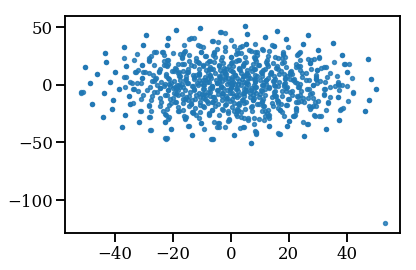

In [116]:
X_til_new = TSNE(random_state=1337).fit_transform(til_svd)
plt.scatter(X_til_new[:,0], X_til_new[:,1], s=15, alpha=0.8);

### K means

In [117]:
res_til = cluster_range(til_svd, KMeans(random_state=1337), 2, 20)

Clustering with k = 2... Done!
Clustering with k = 3... Done!
Clustering with k = 4... Done!
Clustering with k = 5... Done!
Clustering with k = 6... Done!
Clustering with k = 7... Done!
Clustering with k = 8... Done!
Clustering with k = 9... Done!
Clustering with k = 10... Done!
Clustering with k = 11... Done!
Clustering with k = 12... Done!
Clustering with k = 13... Done!
Clustering with k = 14... Done!
Clustering with k = 15... Done!
Clustering with k = 16... Done!
Clustering with k = 17... Done!
Clustering with k = 18... Done!
Clustering with k = 19... Done!
Clustering with k = 20... Done!


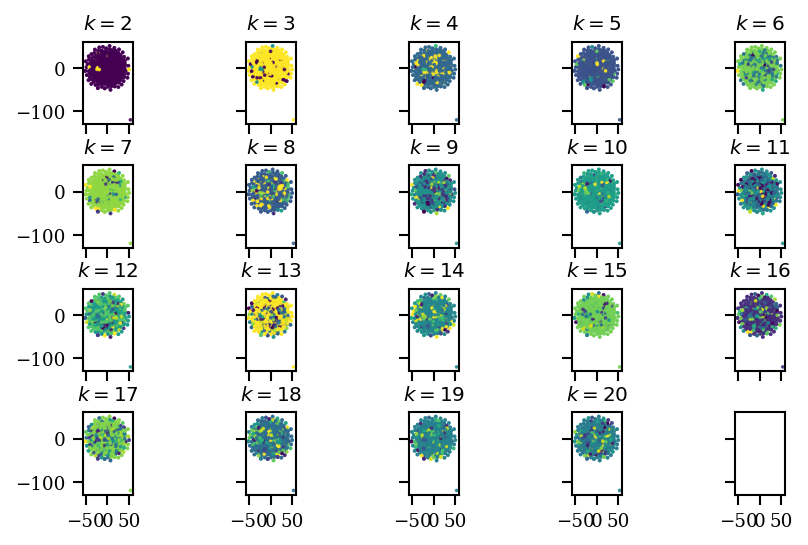

In [118]:
sns.set_context("paper")
plot_clusters(X_til_new, res_til['ys'])
plt.show()
sns.set_context("talk")

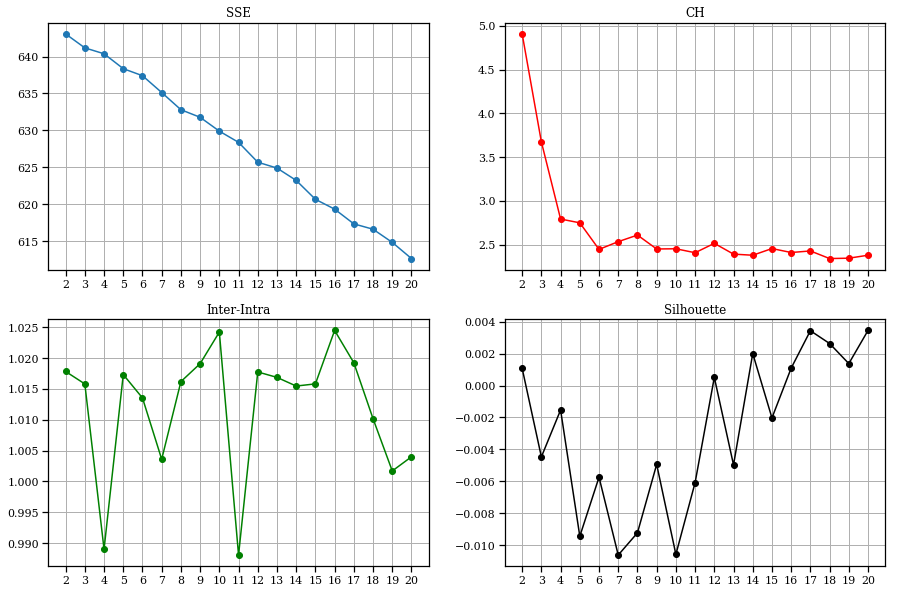

In [120]:
sns.set_context('notebook')
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
ax[0][0].plot(np.arange(2, len(res_til['inertias'])+2), res_til['inertias'], 
              'o-')
ax[0][0].set_xticks(np.arange(2, len(res_til['inertias'])+2))
ax[0][0].set_title("SSE")
ax[0][0].grid()
ax[0][1].plot(np.arange(2, len(res_til['chs'])+2), res_til['chs'], 'ro-')
ax[0][1].set_xticks(np.arange(2, len(res_til['chs'])+2))
ax[0][1].set_title("CH")
ax[0][1].grid()
ax[1][0].plot(np.arange(2, len(res_til['iidrs'])+2), res_til['iidrs'], 'go-')
ax[1][0].set_xticks(np.arange(2, len(res_til['iidrs'])+2))
ax[1][0].set_title("Inter-Intra")
ax[1][0].grid()
ax[1][1].plot(np.arange(2, len(res_til['scs'])+2), res_til['scs'], 'ko-')
ax[1][1].set_xticks(np.arange(2, len(res_til['scs'])+2))
ax[1][1].set_title("Silhouette")
ax[1][1].grid()
plt.show()

#### ANALYSIS
**SSE** - There is a downward trend in SSE, thus increasing `k` will lower SSE. However, we cannot just keep on increasing `k` because the clustering will no longer be parsimonious (low number of k) and the clusters might not make sense. Thus, we want to keep `k` low.

**CH** - for Calinski-Harabasz index (CH), we want larger values. Thus, based on the plot above, we might pick <b>4, 5, or 8</b> clusters to hit a compromise at the 'elbow' of the graph.

**Inter-Intra** - A lower value of inter-intra is preferable. However, looking at the plot, there is no clear trend emerging yet at `k` = 2 to `k` = 20. This, we might pick <b>4</b> or <b>7</b> clusters as they are local minima.

**Silhouette** - This coefficient is best if maximized. Although the variations are small (they seem large in the plot due to the y-axis limits), if we want to keep the clusters parsimonious, then we might want to pick <b>5</b> or <b>7</b> clusters.

#### VERDICT
Based on the criteria above, pick <b>4</b> clusters and examine the output. If unsatisfied, try <b>5</b>, or <b>7</b> clusters.

Using K means with n_clusters = 5, we visualize once again using TSNE.

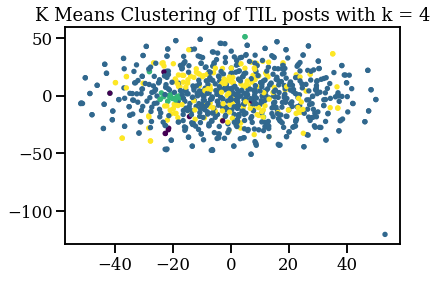

Number of members in cluster 2: 633
Number of members in cluster 4: 168
Number of members in cluster 3: 20
Number of members in cluster 1: 9


In [123]:
produce_kmeans_cluster_til(4)

#### ANALYSIS
From looking at the TSNE visualization, we can see that the clustering assigned most of the members to cluster 1 (purple cluster above). However, before we discount this clustering and try something else, let us take a look at the clusters formed.

Assigning the targets as identified by K Means (k = 6) to the DataFrame `clean_df`.

In [124]:
clean_df1.head()

author                                        clean_title  \
10     [deleted]  til maternal kisses are not effective in allev...   
22     [deleted]  til goldman sachs did a study in 2009 that est...   
31  MattValentin  til the justice leagues martian manhunter was ...   
38    scotchleaf  til that the top 25 hedge fund managers in the...   
47     [deleted]  til leonard howell the first rasta preached th...   

                                         no_til_title  kmeans_5  kmeans_4  
10  maternal kisses are not effective in alleviati...         1         1  
22  goldman sachs did a study in 2009 that estimat...         1         1  
31  the justice leagues martian manhunter was once...         1         3  
38  that the top 25 hedge fund managers in the us ...         3         3  
47  leonard howell the first rasta preached that r...         1         1

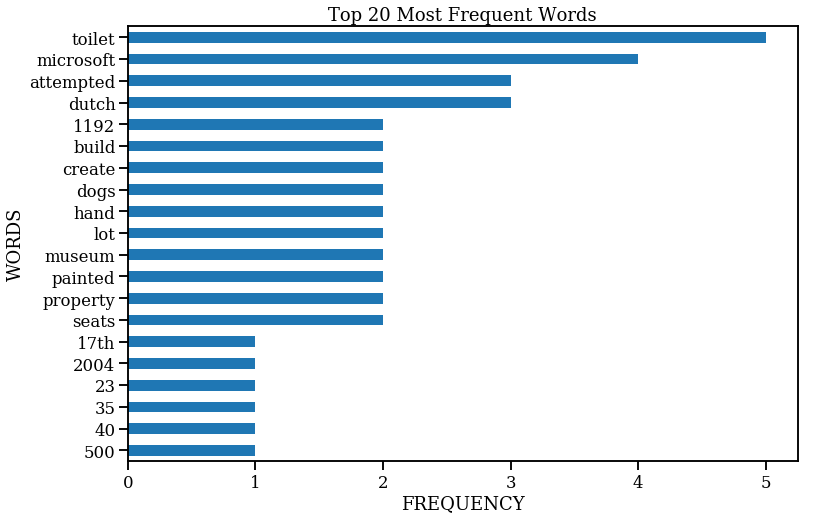

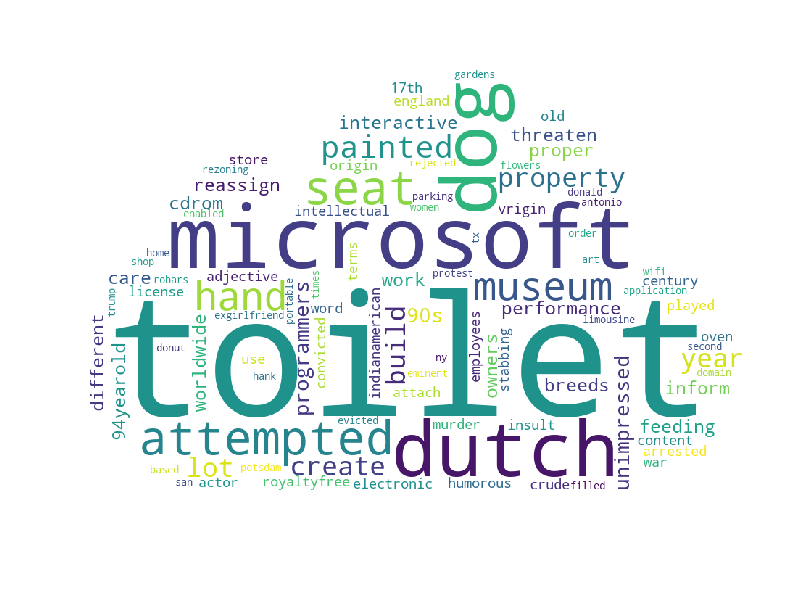

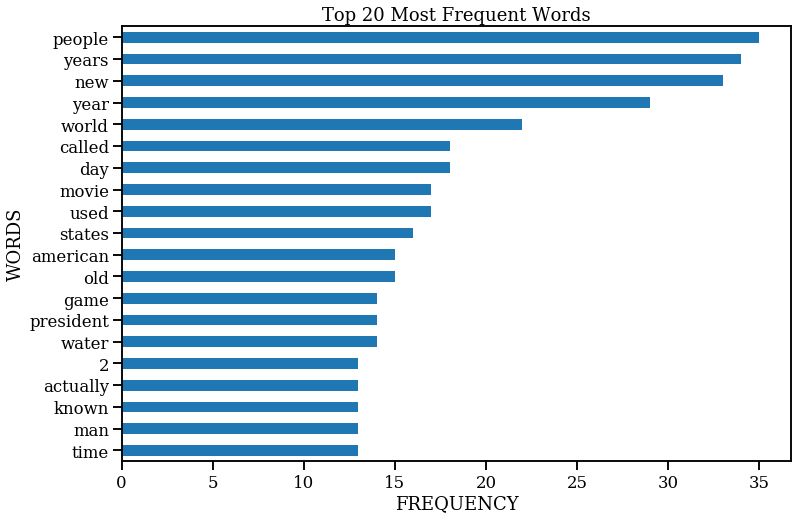

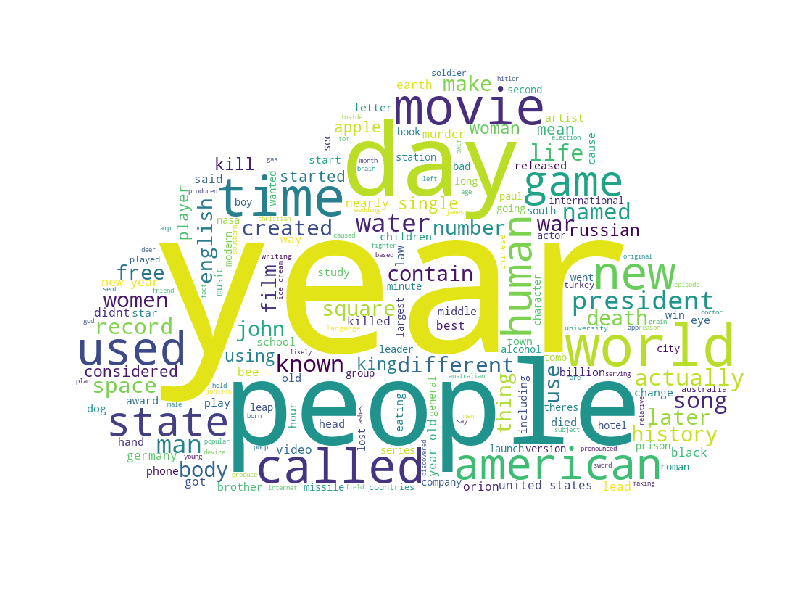

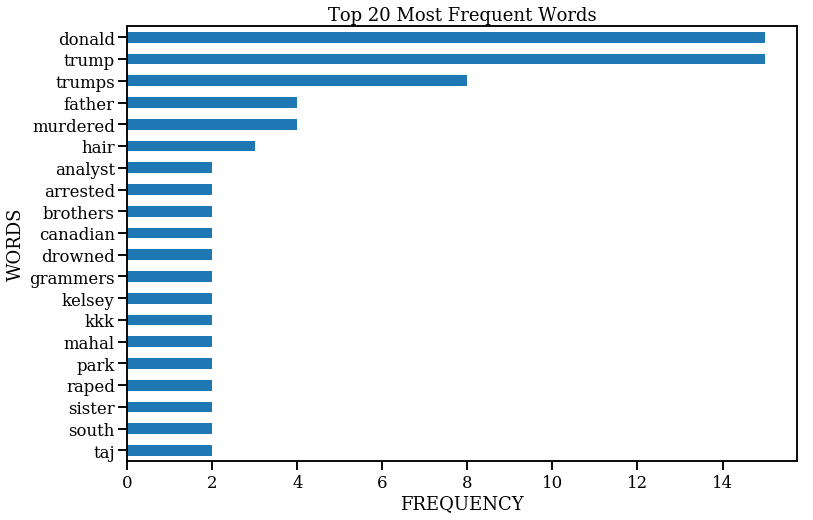

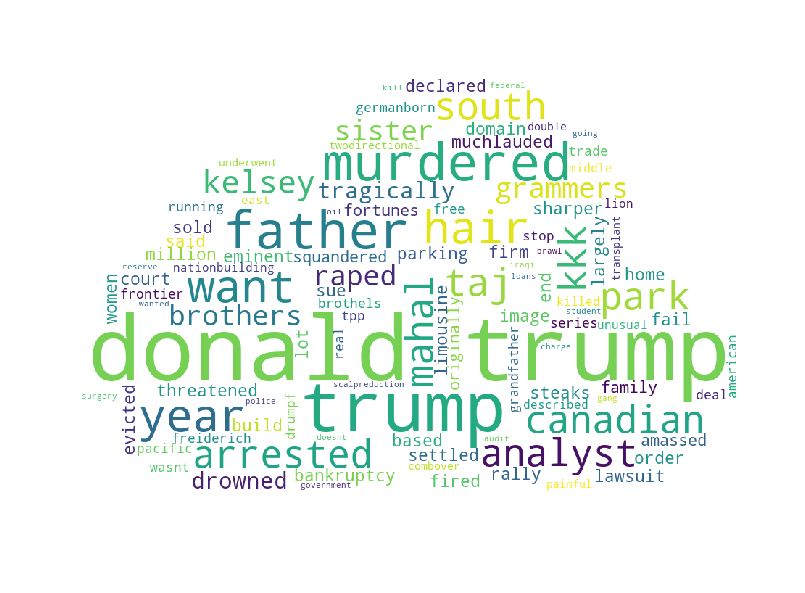

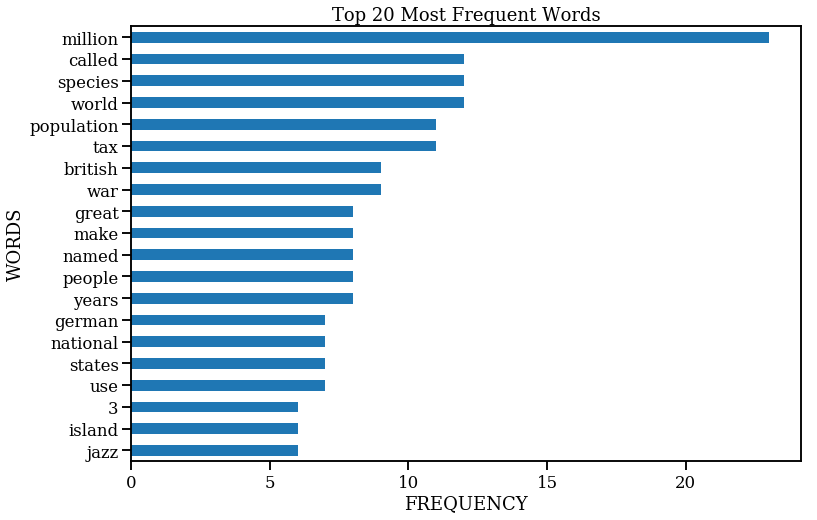

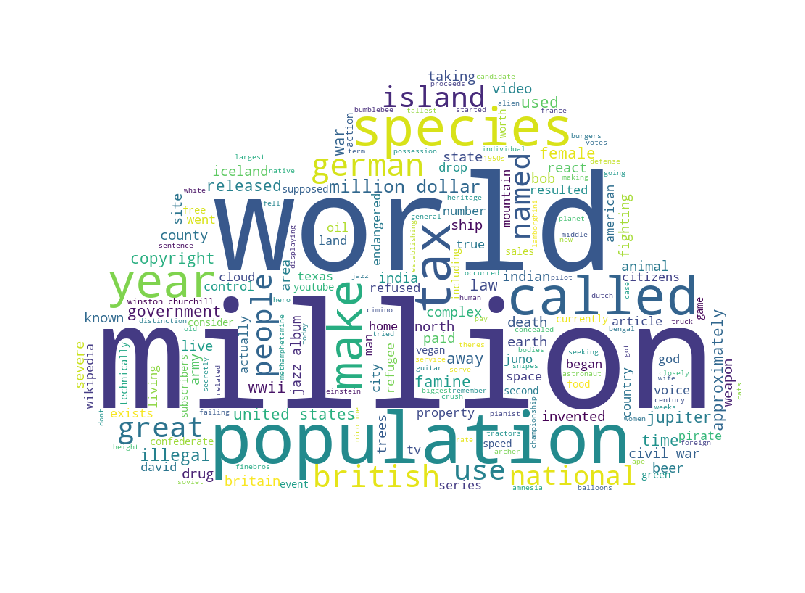

In [126]:
illustrate_clusters(clean_df1, 4)